In [598]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cdist
import nltk
from nltk.corpus import stopwords
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import pearsonr
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, TargetEncoder, LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import plot_importance


In [599]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [600]:
df = pd.read_csv('./data/all_jobs.csv')

In [601]:
df.head()

Unnamed: 0                                         Job Title  \
0           0  Business Analyst - Clinical & Logistics Platform   
1           1                                  Business Analyst   
2           2                                      Data Analyst   
3           3   Information Security Analyst, Incident Response   
4           4                     Analyst - FP&A Global Revenue   

               Salary Estimate  \
0  $56K-$102K (Glassdoor est.)   
1  $56K-$102K (Glassdoor est.)   
2  $56K-$102K (Glassdoor est.)   
3  $56K-$102K (Glassdoor est.)   
4  $56K-$102K (Glassdoor est.)   

                                     Job Description  Rating  \
0  Company Overview\n\n\nAt Memorial Sloan Ketter...     3.9   
1  We are seeking for an energetic and collaborat...     3.8   
2  For more than a decade, Asembia has been worki...     3.6   
3  Job Description Summary\nThe Information Secur...     3.6   
4  Magnite is the world's largest independent sel...     3.4   

                    Company Name            Location        Headquarters  \
0  Memorial Sloan-Kettering\n3.9        New York, NY        New York, NY   
1   Paine Schwartz Partners\n3.8        New York, NY        New York, NY   
2                   Asembia\n3.6    Florham Park, NJ    Florham Park, NJ   
3                        BD\n3.6  Franklin Lakes, NJ  Franklin Lakes, NJ   
4           Rubicon Project\n3.4        New York, NY     Los Angeles, CA   

                    Size  Founded       Type of ownership  \
0       10000+ employees     1884  Nonprofit Organization   
1      1 to 50 employees       -1       Company - Private   
2  501 to 1000 employees     2004       Company - Private   
3       10000+ employees     1897        Company - Public   
4   201 to 500 employees     2007        Company - Public   

                             Industry                     Sector  \
0    Health Care Services & Hospitals                Health Care   
1    Venture Capital & Private Equity                    Finance   
2           Biotech & Pharmaceuticals  Biotech & Pharmaceuticals   
3  Health Care Products Manufacturing              Manufacturing   
4                            Internet     Information Technology   

                      Revenue  \
0      $2 to $5 billion (USD)   
1    Unknown / Non-Applicable   
2     $5 to $10 million (USD)   
3          $10+ billion (USD)   
4  $100 to $500 million (USD)   

                                         Competitors Easy Apply  
0  Mayo Clinic, The Johns Hopkins Hospital, MD An...         -1  
1                                                 -1       True  
2                                                 -1         -1  
3                            Abbott, Siemens, Baxter         -1  
4                 PubMatic, AppNexus, Index Exchange       True

In [602]:
pd.set_option('display.max_colwidth', None)
# df['Job Description'].head()



In [603]:
pd.reset_option('display.max_colwidth')

In [604]:
df.drop(['Unnamed: 0', 'Competitors', 'Easy Apply'], axis=1, inplace=True)

In [605]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26980 entries, 0 to 26979
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job Title          26980 non-null  object 
 1   Salary Estimate    26980 non-null  object 
 2   Job Description    26980 non-null  object 
 3   Rating             26980 non-null  float64
 4   Company Name       26975 non-null  object 
 5   Location           26980 non-null  object 
 6   Headquarters       26980 non-null  object 
 7   Size               26980 non-null  object 
 8   Founded            26980 non-null  int64  
 9   Type of ownership  26980 non-null  object 
 10  Industry           26980 non-null  object 
 11  Sector             26980 non-null  object 
 12  Revenue            26980 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 2.7+ MB


In [606]:
df.fillna({'Company Name':'Unknown'}, inplace=True)

Job Title               0
Salary Estimate        47
Job Description         0
Rating               2375
Company Name            5
Location                0
Headquarters         1404
Size                 1882
Founded              6698
Type of ownership    1550
Industry             3487
Sector               3484
Revenue              1331
dtype: int64


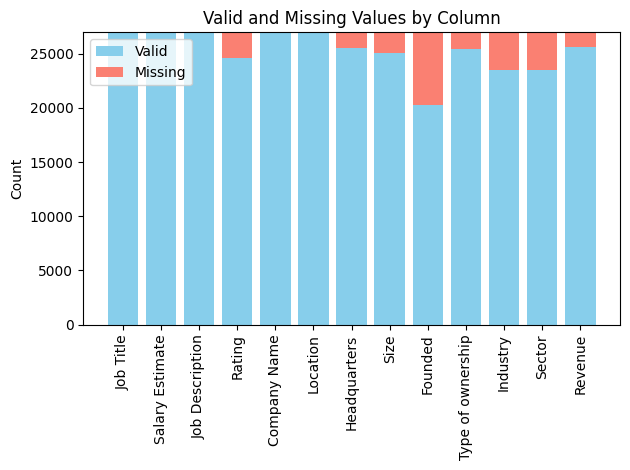

In [607]:
missing_counts = df.replace({-1: np.nan, '-1': np.nan,'Unknown': np.nan}).isnull().sum()
valid_counts = df.replace({-1: np.nan, '-1': np.nan,'Unknown': np.nan}).notnull().sum()
print(missing_counts)

categories = df.columns
x = range(len(categories))

plt.bar(x, valid_counts, label='Valid', color='skyblue')
plt.bar(x, missing_counts, bottom=valid_counts, label='Missing', color='salmon')
plt.xticks(x, categories, rotation=90)
plt.ylabel('Count')
plt.title('Valid and Missing Values by Column')
plt.legend()

plt.tight_layout()
plt.show()

**Salary**

In [608]:
unique_salaries = df['Salary Estimate'].nunique()
print(unique_salaries)

# print(df['Salary Estimate'].value_counts().head(10))
# print(df['Salary Estimate'].value_counts().tail(10))



819


In [609]:
per_hour = df['Salary Estimate'].str.contains('Per Hour', case=False, na=False)
per_hour_count = per_hour.sum()
per_year = df['Salary Estimate'].str.contains(r'\$\d+K-\$\d+K', case=False, na=False)
per_year_count = per_year.sum()
other_format = df[~(per_hour | per_year)]
print(f"per_hour_count: {per_hour_count}")
print(f"per_year_count: {per_year_count}")
# print(other_format['Salary Estimate'])
print(other_format.shape[0])


per_hour_count: 114
per_year_count: 26819
47


In [610]:
df = df[~per_hour]
df = df[df['Salary Estimate'] != '-1']


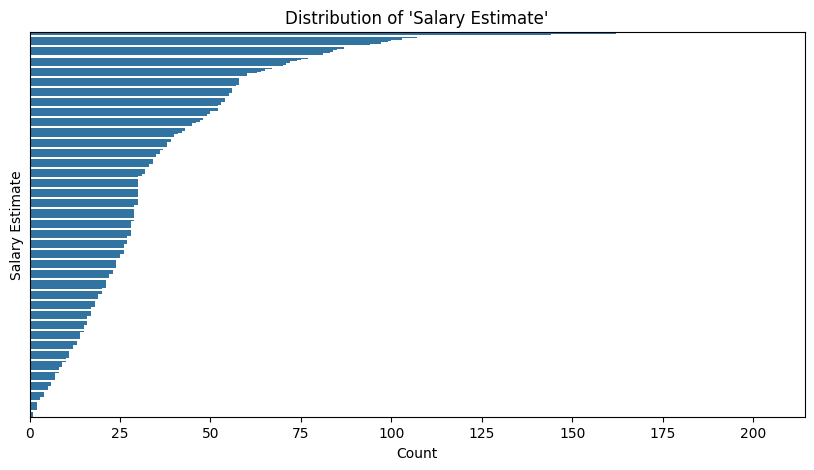

In [611]:
plt.figure(figsize=(10, 5))
sns.countplot(
    y=df['Salary Estimate'],
    order=df['Salary Estimate'].value_counts().index
)
plt.yticks([])
plt.title("Distribution of 'Salary Estimate'")
plt.xlabel("Count")
plt.ylabel("Salary Estimate")
plt.show()


In [612]:
# Salary Estimate to 2 columns: Salary Min and Salary Max
df['Salary Min'] = df['Salary Estimate'].str.extract(r'(\d+)K')[0].astype(float) * 1000
df['Salary Max'] = df['Salary Estimate'].str.extract(r'-\$(\d+)K')[0].astype(float) * 1000
print(df[['Salary Estimate', 'Salary Min', 'Salary Max']].head())


               Salary Estimate  Salary Min  Salary Max
0  $56K-$102K (Glassdoor est.)     56000.0    102000.0
1  $56K-$102K (Glassdoor est.)     56000.0    102000.0
2  $56K-$102K (Glassdoor est.)     56000.0    102000.0
3  $56K-$102K (Glassdoor est.)     56000.0    102000.0
4  $56K-$102K (Glassdoor est.)     56000.0    102000.0


In [613]:
# check if there's no not integer values
not_integer_min = df[~df['Salary Min'].apply(float.is_integer)]
not_integer_max = df[~df['Salary Max'].apply(float.is_integer)]

print(not_integer_min[['Salary Estimate', 'Salary Min']].head())
print(not_integer_max[['Salary Estimate', 'Salary Max']].head())


Empty DataFrame
Columns: [Salary Estimate, Salary Min]
Index: []
Empty DataFrame
Columns: [Salary Estimate, Salary Max]
Index: []


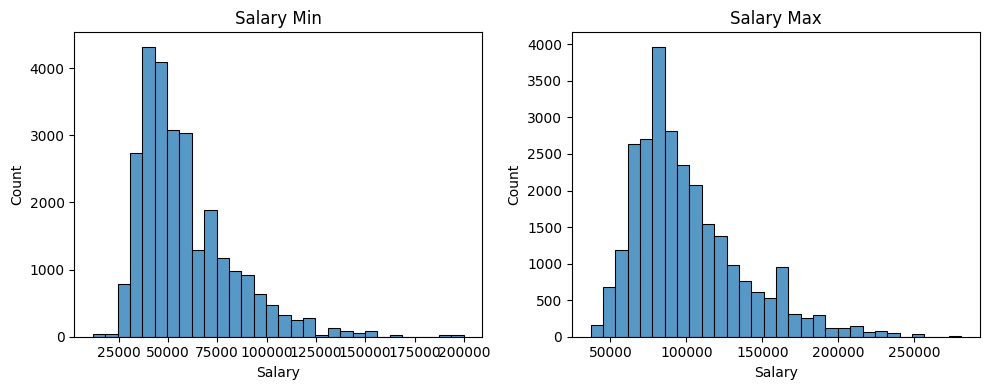

In [614]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(df['Salary Min'], bins=30, ax=axes[0])
axes[0].set_title("Salary Min")
axes[0].set_xlabel("Salary")
axes[0].set_ylabel("Count")

sns.histplot(df['Salary Max'], bins=30, ax=axes[1])
axes[1].set_title("Salary Max")
axes[1].set_xlabel("Salary")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [615]:
df['SalaryAvg'] = (df['Salary Min'] + df['Salary Max']) / 2

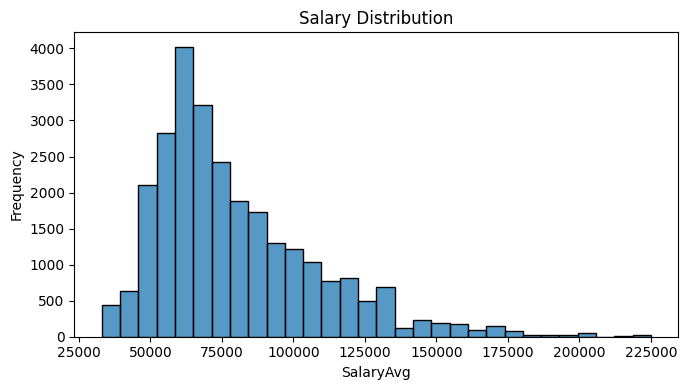

In [616]:
plt.figure(figsize=(7, 4))
sns.histplot(df['SalaryAvg'], bins=30)
plt.title('Salary Distribution')
plt.xlabel('SalaryAvg')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [617]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26819 entries, 0 to 26979
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job Title          26819 non-null  object 
 1   Salary Estimate    26819 non-null  object 
 2   Job Description    26819 non-null  object 
 3   Rating             26819 non-null  float64
 4   Company Name       26819 non-null  object 
 5   Location           26819 non-null  object 
 6   Headquarters       26819 non-null  object 
 7   Size               26819 non-null  object 
 8   Founded            26819 non-null  int64  
 9   Type of ownership  26819 non-null  object 
 10  Industry           26819 non-null  object 
 11  Sector             26819 non-null  object 
 12  Revenue            26819 non-null  object 
 13  Salary Min         26819 non-null  float64
 14  Salary Max         26819 non-null  float64
 15  SalaryAvg          26819 non-null  float64
dtypes: float64(4), int64(1), ob

Numerical values

In [618]:
df.describe()

Rating       Founded     Salary Min     Salary Max      SalaryAvg
count  26819.000000  26819.000000   26819.000000   26819.000000   26819.000000
mean       3.308367   1482.958947   58803.572094  100606.137440   79704.854767
std        1.470870    853.573244   23883.466818   35849.781378   28810.691955
min       -1.000000     -1.000000   12000.000000   37000.000000   33000.000000
25%        3.200000   1775.000000   42000.000000   76000.000000   60000.000000
50%        3.700000   1976.000000   52000.000000   91000.000000   71500.000000
75%        4.000000   2001.000000   71000.000000  118500.000000   93000.000000
max        5.000000   2020.000000  200000.000000  281000.000000  225000.000000

In [619]:
df.drop(['Salary Estimate', 'Salary Min', 'Salary Max'], axis=1, inplace=True)

In [620]:
df_filtered = df[df != -1].dropna()
df_filtered.describe()


Rating       Founded      SalaryAvg
count  19981.000000  19981.000000   19981.000000
mean       3.735784   1972.281868   79722.961814
std        0.578335     50.428712   28973.916686
min        1.000000   1625.000000   33000.000000
25%        3.400000   1962.000000   60000.000000
50%        3.700000   1994.000000   71500.000000
75%        4.100000   2004.000000   93000.000000
max        5.000000   2020.000000  225000.000000

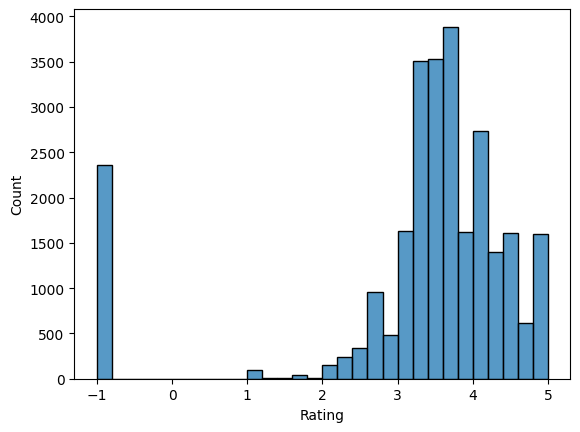

In [621]:
sns.histplot(df['Rating'], bins=30)
plt.xlabel('Rating')
plt.show()

In [622]:
df['Rating'] = df['Rating'].replace(-1, df[df['Rating'] != -1]['Rating'].mean())
df[['Rating']].describe()

Rating
count  26819.000000
mean       3.723687
std        0.611590
min        1.000000
25%        3.400000
50%        3.723687
75%        4.000000
max        5.000000

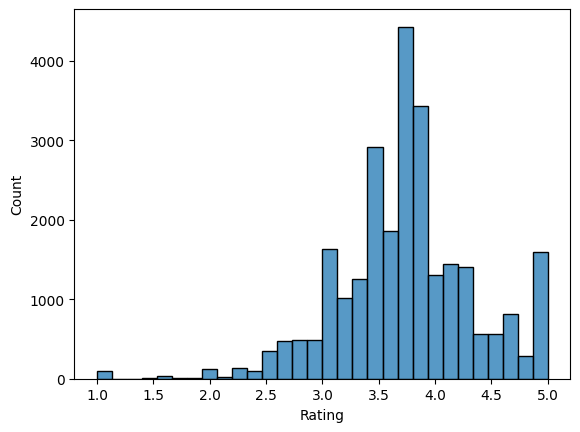

In [623]:
sns.histplot(df['Rating'], bins=30)
plt.xlabel('Rating')
plt.show()

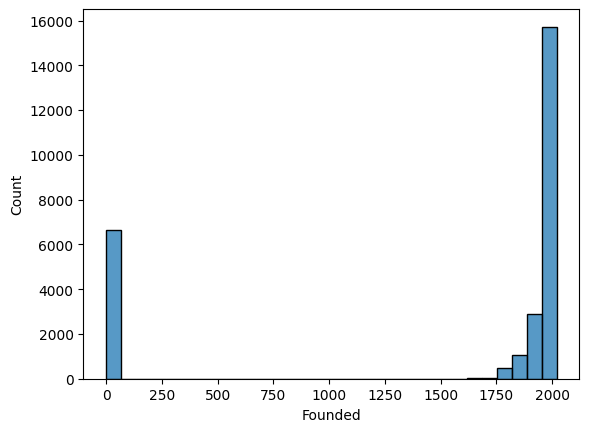

In [624]:
sns.histplot(df['Founded'], bins=30)
plt.xlabel('Founded')
plt.show()

In [625]:
# checking some of the oldest companies
df[(df['Founded'] < 1750) & (df['Founded'] > 0)].head(3)

Job Title  \
42                                     Business Analyst   
82    AVP Markets Execution Business Analyst - Proje...   
1822            Contactless Card Fraud Strategy Analyst   

                                        Job Description  Rating  \
42    Business Analyst Whippany, NJThe US Consumer B...     3.8   
82    AVP Markets Execution Business Analyst - Proje...     3.8   
1822  Contactless Fraud Strategy Sr. Analyst\nWilmin...     3.8   

            Company Name        Location            Headquarters  \
42         Barclays\n3.8    Whippany, NJ  London, United Kingdom   
82    Barclays Bank\n3.8    New York, NY  London, United Kingdom   
1822       Barclays\n3.8  Wilmington, DE  London, United Kingdom   

                  Size  Founded Type of ownership               Industry  \
42    10000+ employees     1690  Company - Public  Banks & Credit Unions   
82    10000+ employees     1690  Company - Public  Banks & Credit Unions   
1822  10000+ employees     1690  Company - Public  Banks & Credit Unions   

       Sector             Revenue  SalaryAvg  
42    Finance  $10+ billion (USD)    66500.0  
82    Finance  $10+ billion (USD)   120000.0  
1822  Finance  $10+ billion (USD)   108500.0

In [626]:
filtered = df[df['Founded'] != -1]['Founded']
mode_founded = filtered.mode()
median_founded = filtered.median()
mean_founded = filtered.mean()
print(mode_founded)
print(median_founded)
print(mean_founded)


0    2008
Name: Founded, dtype: int64
1994.0
1972.6322836598065


            Founded
count  26819.000000
mean    1981.407286
std       46.243027
min     1625.000000
25%     1976.000000
50%     2001.000000
75%     2008.000000
max     2020.000000


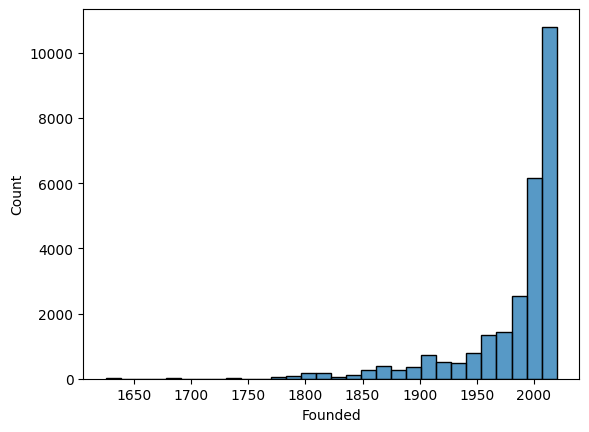

In [627]:
df['Founded'] = df['Founded'].replace(-1, df[df['Founded'] != -1]['Founded'].mode()[0])
print(df[['Founded']].describe())
sns.histplot(df['Founded'], bins=30)
plt.xlabel('Founded')
plt.show()

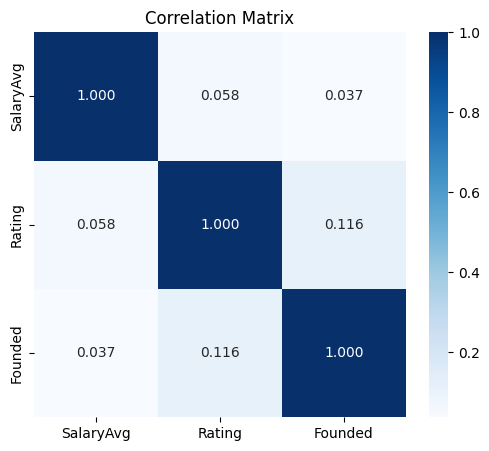

In [628]:
correlation_matrix = df[['SalaryAvg', 'Rating', 'Founded']].corr()
# print(correlation_matrix)
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.3f')
plt.title('Correlation Matrix')
plt.show()


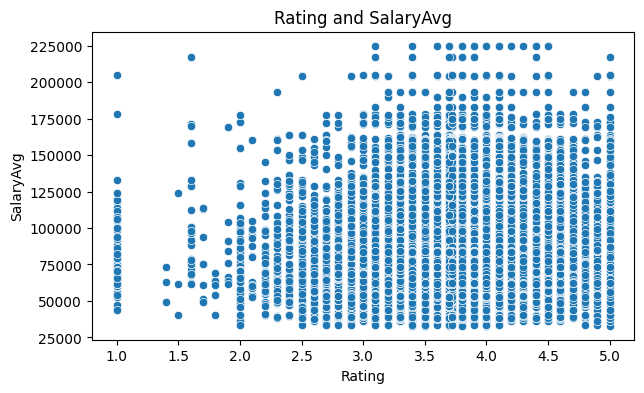

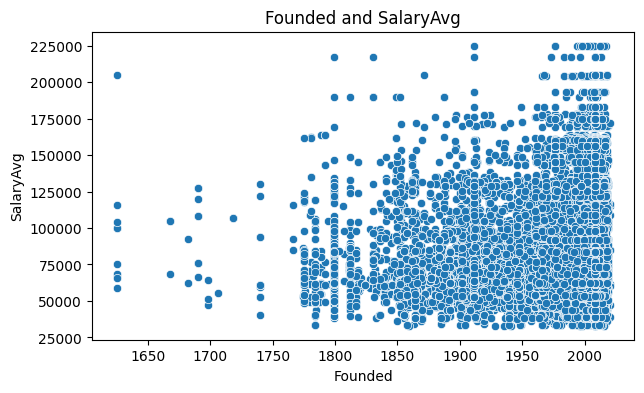

In [629]:
plt.figure(figsize=(7, 4))
sns.scatterplot(x='Rating', y='SalaryAvg', data=df)
plt.title('Rating and SalaryAvg')
plt.show()

plt.figure(figsize=(7, 4))
sns.scatterplot(x='Founded', y='SalaryAvg', data=df)
plt.title('Founded and SalaryAvg')
plt.show()

In [630]:
df.drop('Founded', axis=1, inplace=True)

In [631]:
df.head(1)

Job Title  \
0  Business Analyst - Clinical & Logistics Platform   

                                     Job Description  Rating  \
0  Company Overview\n\n\nAt Memorial Sloan Ketter...     3.9   

                    Company Name      Location  Headquarters  \
0  Memorial Sloan-Kettering\n3.9  New York, NY  New York, NY   

               Size       Type of ownership                          Industry  \
0  10000+ employees  Nonprofit Organization  Health Care Services & Hospitals   

        Sector                 Revenue  SalaryAvg  
0  Health Care  $2 to $5 billion (USD)    79000.0

**Job Titles to categories**

In [632]:
df['JobCategory'] = None
df['Job Title'] = df['Job Title'].str.lower()
# Data Analyst
df.loc[
    (df['Job Title'].str.contains(r'data', na=False, flags=re.IGNORECASE)) &
    (df['Job Title'].str.contains(r'analyst|analysis|analytics', na=False, flags=re.IGNORECASE)) &
    (~df['Job Title'].str.contains(r'engineer|engineering', na=False, flags=re.IGNORECASE)),
    'JobCategory'
] = 'Data Analyst'

# Business Analyst
df.loc[
    (df['Job Title'].str.contains(r'business', na=False, flags=re.IGNORECASE)) &
    (df['Job Title'].str.contains(r'analyst|analysis|intelligence|analytics', na=False, flags=re.IGNORECASE)),
    'JobCategory'
] = 'Business Analyst'

# Data Scientist
df.loc[
    (df['Job Title'].str.contains(r'data', na=False, flags=re.IGNORECASE)) &
    (df['Job Title'].str.contains(r'scientist|science', na=False, flags=re.IGNORECASE)),
    'JobCategory'
] = 'Data Scientist'

# Data Engineer
df.loc[
    (df['Job Title'].str.contains(r'data|BI', na=False, flags=re.IGNORECASE)) &
    (df['Job Title'].str.contains(r'engineer|developer|technician|architect|modeler', na=False, flags=re.IGNORECASE)),
    'JobCategory'
] = 'Data Engineer'

# Manager
df.loc[
    (df['Job Title'].str.contains(r'manager', na=False, flags=re.IGNORECASE)),
    'JobCategory'
] = 'Manager'

# Software Engineers
df.loc[
    (df['Job Title'].str.contains(r'software', na=False, flags=re.IGNORECASE)) &
    (df['Job Title'].str.contains(r'engineer|developer', na=False, flags=re.IGNORECASE)),
    # (~df['Job Title'].str.contains(r'[Dd]ata', na=False, flags=re.IGNORECASE)),
    'JobCategory'
] = 'Other Engineers'

# ML/AI Engineer
df.loc[
    (df['Job Title'].str.contains(r'machine learning|ml|artificial|ai', na=False, flags=re.IGNORECASE)) &
    (df['Job Title'].str.contains(r'engineer', na=False, flags=re.IGNORECASE)),
    # (~df['Job Title'].str.contains(r'[Dd]ata', na=False, flags=re.IGNORECASE)),
    'JobCategory'
] = 'ML/AI Engineer'

# Consultants
df.loc[
    (df['Job Title'].str.contains(r'consultant|consulting', na=False, flags=re.IGNORECASE)),
    'JobCategory'
] = 'Consultant'
print(df['JobCategory'].isna().sum())



8093


In [633]:
print(df[['Job Title', 'JobCategory']].head(10))

                                          Job Title       JobCategory
0  business analyst - clinical & logistics platform  Business Analyst
1                                  business analyst  Business Analyst
2                                      data analyst      Data Analyst
3   information security analyst, incident response              None
4                     analyst - fp&a global revenue              None
5                                      data analyst      Data Analyst
6                     investment analyst - graduate              None
7                      it business process analysis  Business Analyst
8                          tolling business analyst  Business Analyst
9                           business analyst - risk  Business Analyst


In [634]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[/,-]', ' ', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['Job Description'] = df['Job Description'].fillna('').apply(clean_text)
df.rename(columns={'Job Description': 'JobDescriptionCleaned'}, inplace=True)

labeled_data = df[df['JobCategory'].notna()].copy()
remaining_data = df[df['JobCategory'].isna()].copy()

labeled_data['JobText'] = (labeled_data['Job Title'] + " " + labeled_data['JobDescriptionCleaned'])
remaining_data['JobText'] = (remaining_data['Job Title'] + " " + remaining_data['JobDescriptionCleaned'])



In [635]:
vectorizer = TfidfVectorizer(stop_words='english')
X_labeled = vectorizer.fit_transform(labeled_data['JobText'])
X_remaining = vectorizer.transform(remaining_data['JobText'])


In [636]:
# XGBClassifier for classification of remaining data
X = X_labeled
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labeled_data['JobCategory'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

model = lgb.LGBMClassifier(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=6,
    class_weight='balanced',
    verbosity=-1
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1379
           1       0.93      0.97      0.95       226
           2       0.92      0.92      0.92      1310
           3       0.90      0.88      0.89       384
           4       0.88      0.94      0.91       217
           5       0.77      0.65      0.71        37
           6       0.83      0.88      0.85       109
           7       0.84      0.93      0.88        84

    accuracy                           0.92      3746
   macro avg       0.88      0.89      0.88      3746
weighted avg       0.92      0.92      0.92      3746



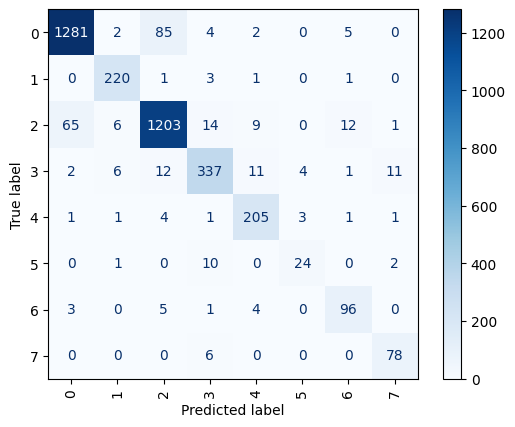

In [637]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')


In [638]:
remaining_data['PredictedCategory'] = label_encoder.inverse_transform(model.predict(X_remaining))
df.loc[df['JobCategory'].isna(), 'JobCategory'] = remaining_data['PredictedCategory']


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [639]:
print(df[['Job Title', 'JobCategory']].head(10))

                                          Job Title       JobCategory
0  business analyst - clinical & logistics platform  Business Analyst
1                                  business analyst  Business Analyst
2                                      data analyst      Data Analyst
3   information security analyst, incident response  Business Analyst
4                     analyst - fp&a global revenue  Business Analyst
5                                      data analyst      Data Analyst
6                     investment analyst - graduate  Business Analyst
7                      it business process analysis  Business Analyst
8                          tolling business analyst  Business Analyst
9                           business analyst - risk  Business Analyst


In [640]:
categories = df['JobCategory'].unique()
palette = sns.color_palette('hls', len(categories))
palette_dict = {category: palette[i] for i, category in enumerate(categories)}

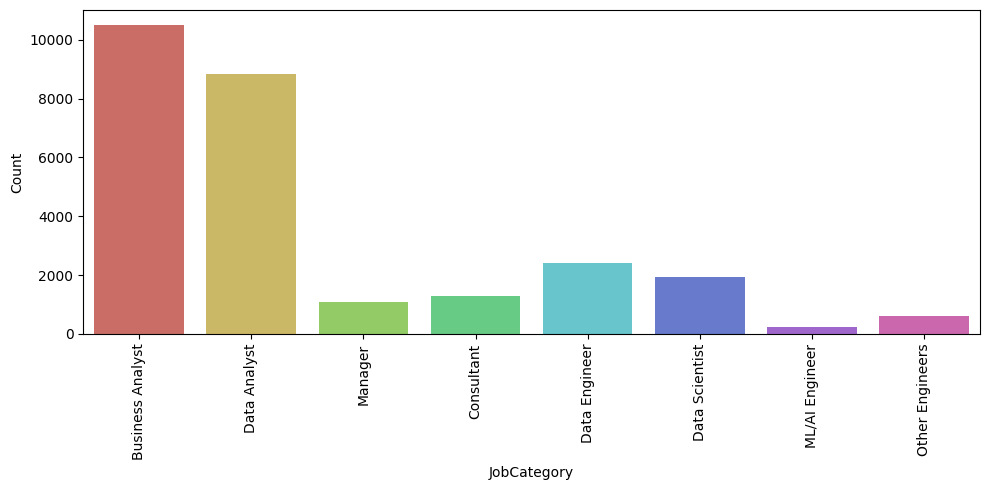

In [641]:
plt.figure(figsize=(10, 5))
sns.countplot(x='JobCategory', data=df, hue = 'JobCategory', legend = False, palette=palette_dict)
plt.xticks(rotation=90)
plt.xlabel('JobCategory')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

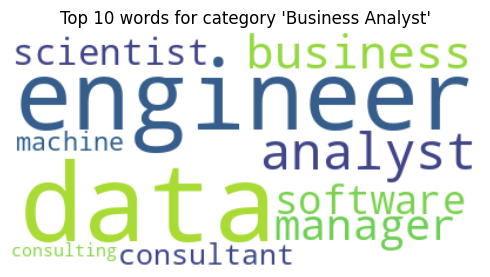

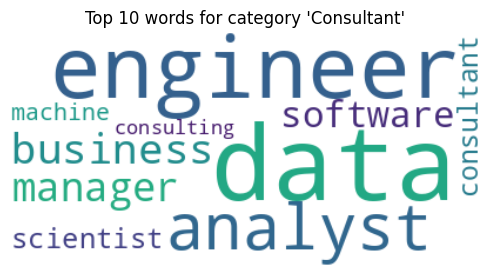

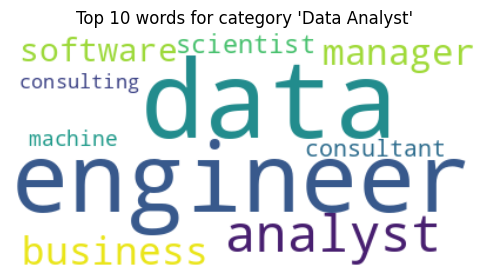

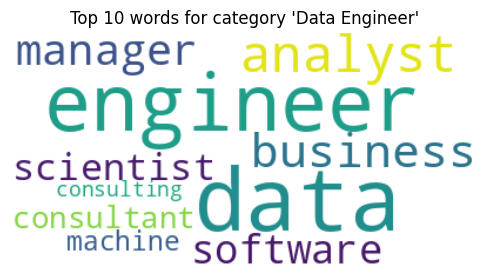

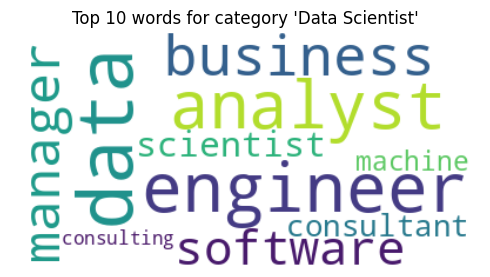

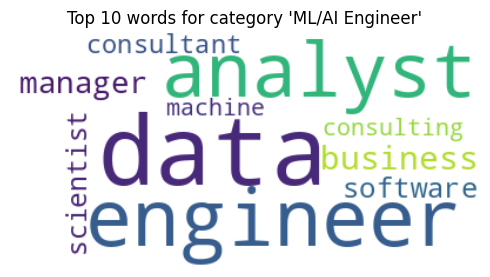

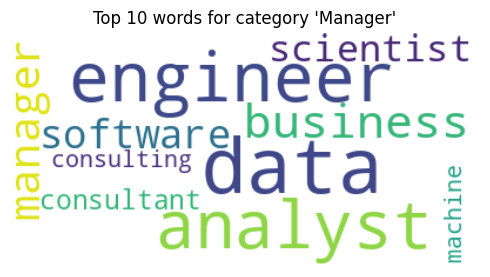

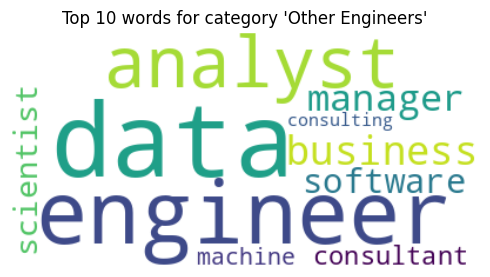

In [642]:
feature_names = np.array(vectorizer.get_feature_names_out())
feature_importances = model.feature_importances_
categories = model.classes_
top_n = 10

for i, category in enumerate(categories):
    category = label_encoder.inverse_transform([category])[0]
    # print(f"Top {top_n} words for category '{category}':")
    top_indices = np.argsort(feature_importances)[-top_n:][::-1]
    top_words = feature_names[top_indices]
    top_weights = feature_importances[top_indices]
    # for word, weight in zip(top_words, top_weights):
    #     print(f"{word}: {weight:.4f}")
    print()

    word_freq = {word: weight for word, weight in zip(top_words, top_weights)}
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(5, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Top {top_n} words for category '{category}'")
    plt.tight_layout()
    plt.show()


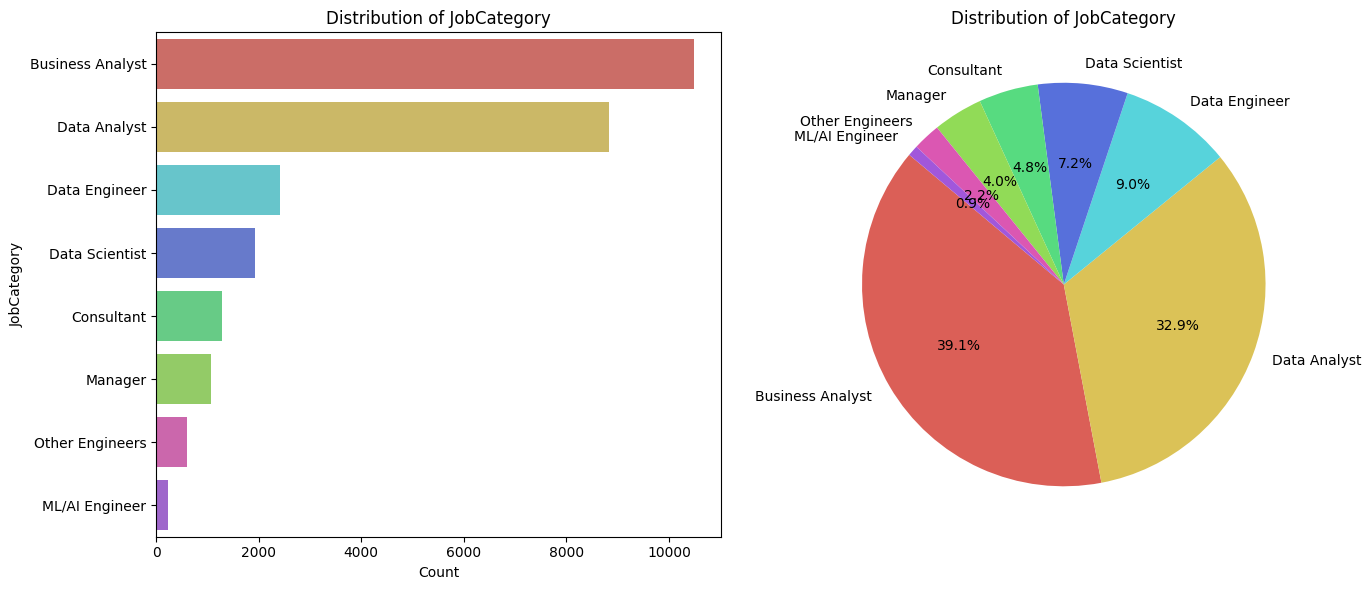

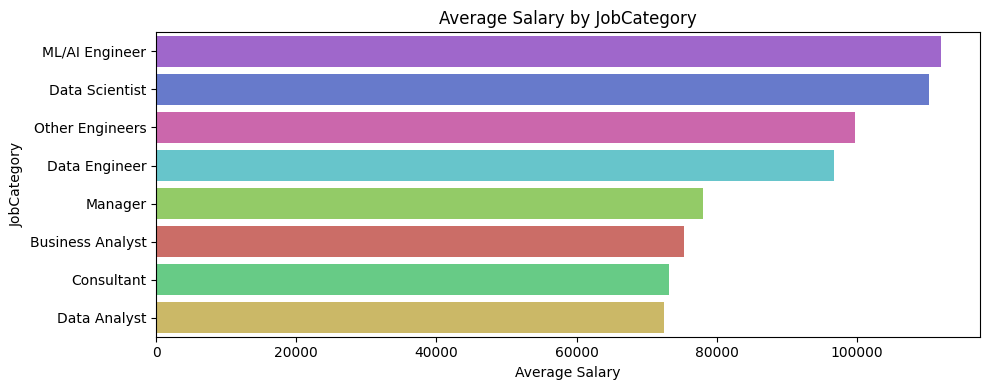

In [643]:
# JobCategory Statistics

category_counts = df['JobCategory'].value_counts()

total_count = category_counts.sum()
threshold = 0.01 * total_count

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(y=category_counts.index, x=category_counts.values, hue=category_counts.index, legend=False,
            palette=palette_dict)
plt.title('Distribution of JobCategory')
plt.xlabel('Count')
plt.ylabel('JobCategory')

plt.subplot(1, 2, 2)
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=140,
        colors=[palette_dict.get(category, 'gray') for category in category_counts.index])
plt.title('Distribution of JobCategory')

plt.tight_layout()
plt.show()

category_salary_avg = df.groupby('JobCategory')['SalaryAvg'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 4))
sns.barplot(y=category_salary_avg.index, x=category_salary_avg.values, hue=category_salary_avg.index, legend=False, palette=palette_dict)
plt.xlabel('Average Salary')
plt.ylabel('JobCategory')
plt.title('Average Salary by JobCategory')
plt.tight_layout()
plt.show()


In [644]:
df.head(1)

Job Title  \
0  business analyst - clinical & logistics platform   

                               JobDescriptionCleaned  Rating  \
0  company overview memorial sloan kettering msk ...     3.9   

                    Company Name      Location  Headquarters  \
0  Memorial Sloan-Kettering\n3.9  New York, NY  New York, NY   

               Size       Type of ownership                          Industry  \
0  10000+ employees  Nonprofit Organization  Health Care Services & Hospitals   

        Sector                 Revenue  SalaryAvg       JobCategory  
0  Health Care  $2 to $5 billion (USD)    79000.0  Business Analyst

**Job Description**

skills

In [645]:
skill_variants = {
    'Python': ['python'],
    'SQL': ['sql', 'structured query language'],
    'NoSQL': ['nosql', 'non relational databases', 'no sql'],
    'Excel': ['excel'],
    'Math': ['linear algebra', 'math'],
    'Statistics':['statistics'],
    'PowerBI':['powerbi', 'power bi'],
    'Tableau':['tableau'],
    'Java': ['java'],
    'JavaScript': ['javascript', 'js'],
'ETL': ['etl', 'extract transform load'],
'Spark': ['spark', 'apache spark'],
'Hadoop': ['hadoop'],
'Teamwork': ['teamwork', 'collaboration'],
'Leadership': ['leadership', 'team management'],
    'API Development': ['api']
}

def extract_skills(description):
    skill_counts = {skill: 0 for skill in skill_variants}
    if pd.notna(description):
        for skill, variants in skill_variants.items():
            for variant in variants:
                if re.search(rf'\b{re.escape(variant)}\b', description, re.IGNORECASE):
                    skill_counts[skill] += 1
                    break
    return skill_counts

skills_df = df['JobDescriptionCleaned'].apply(extract_skills).apply(pd.Series)

categories = pd.get_dummies(df['JobCategory'])
skill_category_matrix = categories.T.dot(skills_df)

grouped_skill_category_matrix = skill_category_matrix.groupby(
    lambda col: next((skill for skill, variants in skill_variants.items() if col in variants), col)).sum()

skill_category_long = (
    grouped_skill_category_matrix.reset_index()
    .melt(id_vars='index', var_name='skill', value_name='frequency')
    .query('frequency > 0')
    .rename(columns={'index': 'jobcategory'})
)



In [ ]:
from ipywidgets import interact

def interactive_plot_skill_distribution(category):
    category_data = skill_category_long[skill_category_long['jobcategory'] == category]

    plt.figure(figsize=(10, 4))
    sns.barplot(
        x='frequency',
        y='skill',
        data=category_data,
        palette='hls', hue = 'skill', legend = False
    )
    plt.title(f'Frequency of Skills in Job Descriptions - {category}')
    plt.xlabel('Frequency')
    plt.ylabel('Skill')
    plt.tight_layout()
    plt.show()

interact(
    interactive_plot_skill_distribution,
    category=skill_category_long['jobcategory'].unique()
)
None

<ipython-input-647-7a3ce4c539fa>:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  relative_skill_category = grouped_skill_category_matrix.div(category_totals, axis=0).fillna(0)


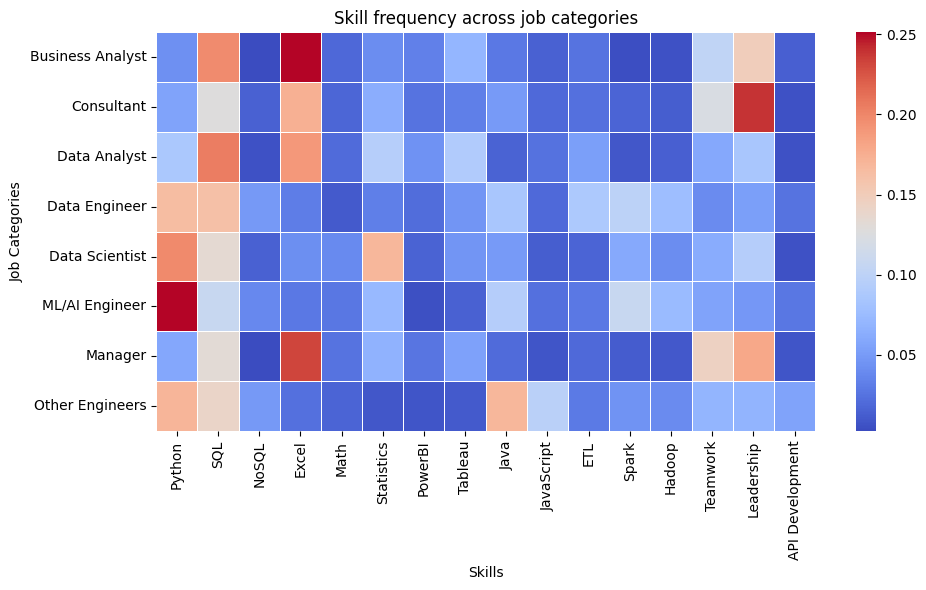

In [647]:
category_totals = grouped_skill_category_matrix.sum(axis=1)
relative_skill_category = grouped_skill_category_matrix.div(category_totals, axis=0).fillna(0)

plt.figure(figsize=(10, 6))
sns.heatmap(
    relative_skill_category,
    annot=False,
    cmap='coolwarm',
    cbar=True,
    linewidths=0.5
)
plt.title('Skill frequency across job categories')
plt.xlabel('Skills')
plt.ylabel('Job Categories')
plt.tight_layout()
plt.show()


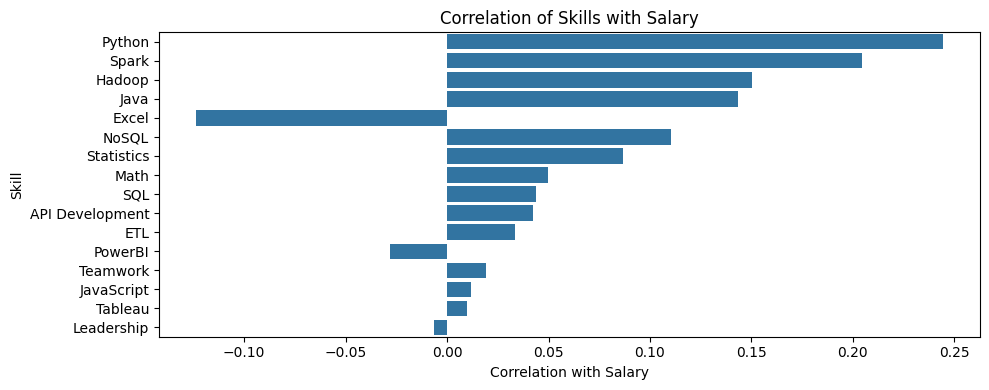

In [648]:
salary_column = df['SalaryAvg'].values

skill_salary_correlation = []

for skill in skills_df.columns:
    skill_values = skills_df[skill].values
    if len(np.unique(skill_values)) > 1:
        correlation, _ = pearsonr(skill_values, salary_column)
    else:
        correlation = np.nan
    skill_salary_correlation.append(correlation)

correlation_df = pd.DataFrame({
    'Skill': skills_df.columns,
    'SalaryCorrelation': skill_salary_correlation
})

correlation_df = correlation_df.dropna().sort_values(by='SalaryCorrelation', key=np.abs, ascending=False)

plt.figure(figsize=(10, 4))
sns.barplot(x='SalaryCorrelation', y='Skill', data=correlation_df)
plt.title('Correlation of Skills with Salary')
plt.xlabel('Correlation with Salary')
plt.ylabel('Skill')
plt.tight_layout()
plt.show()



In [649]:
skills_correlated = correlation_df[correlation_df['SalaryCorrelation'].abs() > 0.2]
selected_skills = skills_correlated['Skill'].values
print(selected_skills)

for skill in selected_skills:
    df[skill] = skills_df[skill]
df.head(1)

['Python' 'Spark']


Job Title  \
0  business analyst - clinical & logistics platform   

                               JobDescriptionCleaned  Rating  \
0  company overview memorial sloan kettering msk ...     3.9   

                    Company Name      Location  Headquarters  \
0  Memorial Sloan-Kettering\n3.9  New York, NY  New York, NY   

               Size       Type of ownership                          Industry  \
0  10000+ employees  Nonprofit Organization  Health Care Services & Hospitals   

        Sector                 Revenue  SalaryAvg       JobCategory  Python  \
0  Health Care  $2 to $5 billion (USD)    79000.0  Business Analyst       0   

   Spark  
0      0

ExperienceLevel

In [650]:
def extract_experience_level(row):
    text = row['Job Title'] + " " + row['JobDescriptionCleaned']
    if re.search(r'\b(intern|trainee|internship)\b', text, re.IGNORECASE):
        return 'Intern/Trainee'
    elif re.search(r'\b(junior|entry level)\b', text, re.IGNORECASE):
        return 'Junior'
    elif re.search(r'\b(middle|mid level|midlevel)\b', text, re.IGNORECASE):
        return 'Middle'
    elif re.search(r'\b(senior|lead|principal)\b', text, re.IGNORECASE):
        return 'Senior'
    else:
        return 'Unknown'

df['ExperienceLevel'] = df.apply(extract_experience_level, axis=1)

# print(df[['Job Title', 'JobDescriptionCleaned', 'ExperienceLevel']].head(10))

experience_counts = df['ExperienceLevel'].value_counts()

print("experience_counts")
print(experience_counts)


experience_counts
ExperienceLevel
Unknown           13698
Senior            10273
Junior             1991
Middle              456
Intern/Trainee      401
Name: count, dtype: int64


In [651]:
filtered_df = df[
    df['JobDescriptionCleaned'].str.contains(r'\bper hour\b', case=False, na=False)
    # &  ~df['Job Description'].str.contains(r'\bpaid\b' , case=False, na=False)
]
count = len(filtered_df)
print(f"per hour: {count}")

experience_level_counts = filtered_df['ExperienceLevel'].value_counts()
print(experience_level_counts)

filtered_df = df[
    (df['ExperienceLevel'] == 'Intern/Trainee') &
    df['JobDescriptionCleaned'].str.contains(r'\bunpaid\b', case=False, na=False)
      &  ~df['JobDescriptionCleaned'].str.contains(r'\bpaid\b' , case=False, na=False)
]
count = len(filtered_df)
print(f"unpaid: {count}")

# filtered_df[['Job Description', 'ExperienceLevel', 'SalaryAvg']]

per hour: 422
ExperienceLevel
Unknown           278
Senior            101
Junior             29
Intern/Trainee     10
Middle              4
Name: count, dtype: int64
unpaid: 8


In [652]:
# Removing rows where 'JobDescriptionCleaned' contains "per hour"
condition = (
    df['JobDescriptionCleaned'].str.contains(r'\bper hour\b', case=False, na=False)
)

df = df[~condition]

print(df.shape)

(26397, 16)


In [653]:
# Removing rows where 'JobDescriptionCleaned' contains "unpaid" for trainees (as in the case of other experience levels, these terms usually appear in a different context)
condition = (
    (df['ExperienceLevel'] == 'Intern/Trainee') &
    df['JobDescriptionCleaned'].str.contains(r'\bunpaid\b', case=False, na=False) &
    ~df['JobDescriptionCleaned'].str.contains(r'\bpaid\b', case=False, na=False)
)

df = df[~condition]

print(df.shape)


(26389, 16)


In [654]:
paired_colors = plt.cm.Paired.colors
experience_colors = {
    'Intern/Trainee': 'plum',
    'Junior': 'yellowgreen',
    'Middle': 'sandybrown',
    'Senior': 'cornflowerblue',
    'Unknown': 'gray'
}

ExperienceLevel   Intern/Trainee  Junior  Middle  Senior  Unknown
JobCategory                                                      
Business Analyst             128     773     208    4101     5075
Consultant                    57     129      30     641      411
Data Analyst                 118     658     121    3076     4699
Data Engineer                 26     145      29     833     1343
Data Scientist                43     143      30     777      926
ML/AI Engineer                 0       6       3      64      154
Manager                        3      54      20     499      476
Other Engineers                8      54      11     181      336


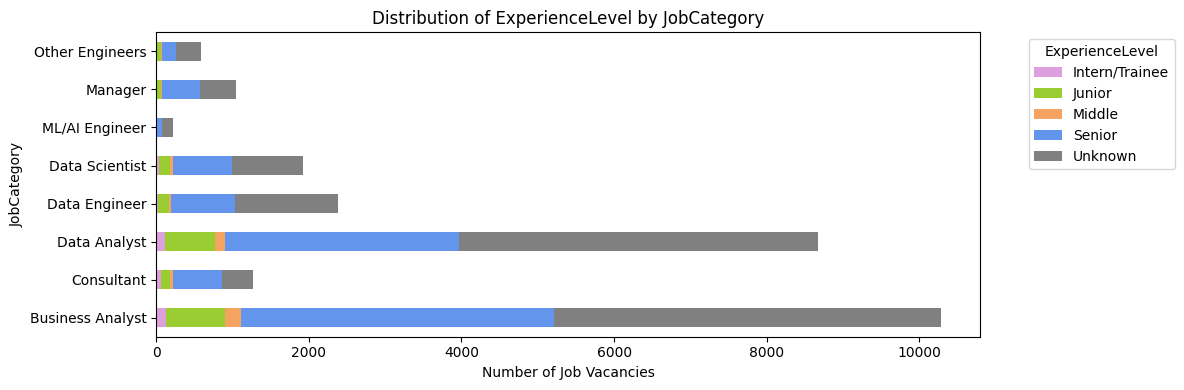

In [655]:
category_level_distribution = df.groupby(['JobCategory', 'ExperienceLevel']).size().unstack(fill_value=0)
print(category_level_distribution)

category_level_distribution.plot(
    kind='barh',
    stacked=True,
    figsize=(12, 4),
    color=[experience_colors.get(level, 'gray') for level in category_level_distribution.columns]
)

plt.title("Distribution of ExperienceLevel by JobCategory")
plt.xlabel("Number of Job Vacancies")
plt.ylabel("JobCategory")
plt.legend(title="ExperienceLevel", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



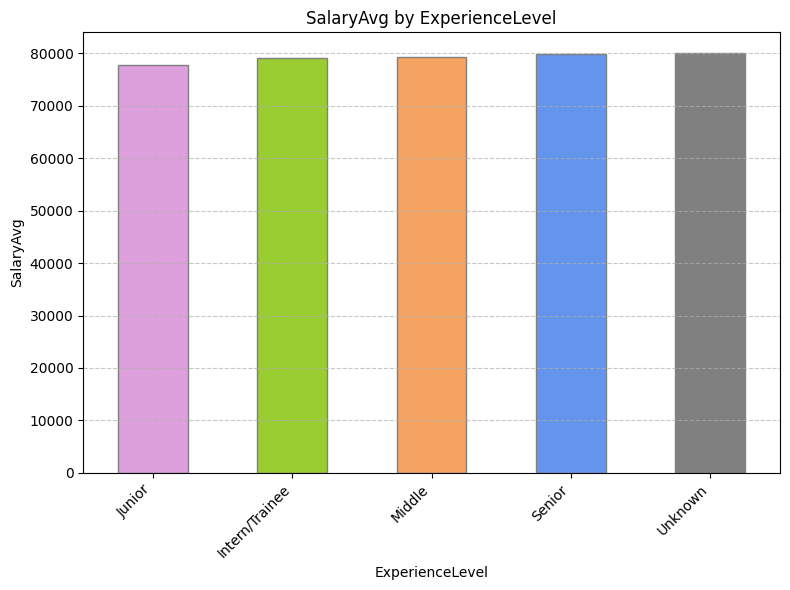

In [656]:
average_salary_by_level = df.groupby('ExperienceLevel')['SalaryAvg'].mean().sort_values()

colors = average_salary_by_level.index.map(lambda x: 'gray' if x == 'Unknown' else 'skyblue')

plt.figure(figsize=(8, 6))
average_salary_by_level.plot(kind='bar', color=[experience_colors.get(level, 'gray') for level in category_level_distribution.columns], edgecolor='gray' )
plt.title("SalaryAvg by ExperienceLevel")
plt.xlabel("ExperienceLevel")
plt.ylabel("SalaryAvg")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


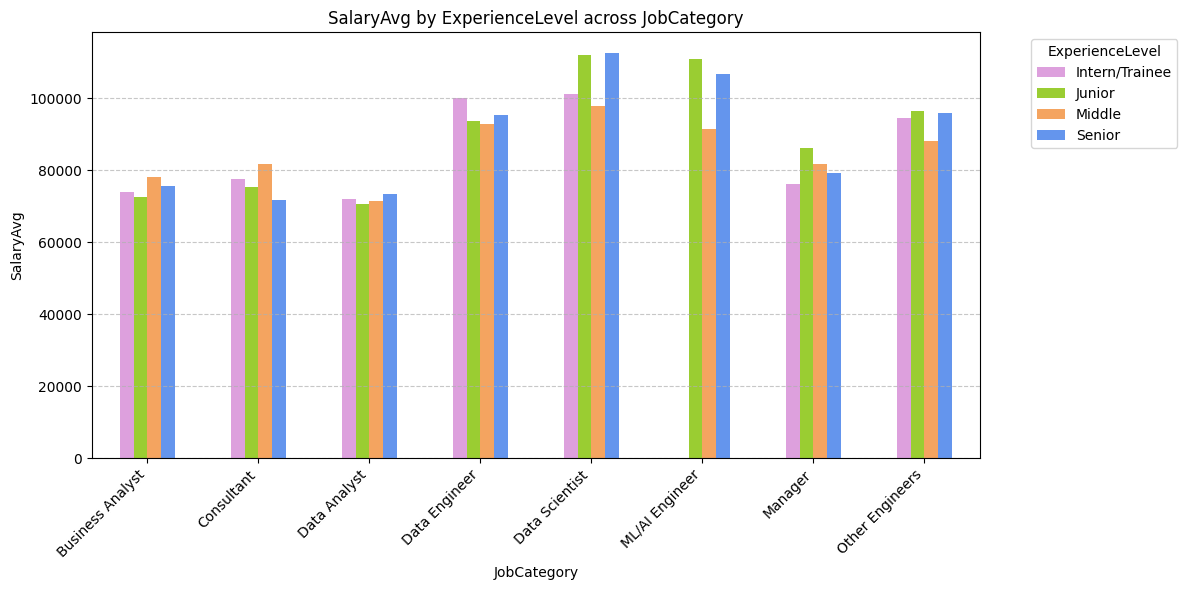

In [657]:

average_salary_by_category_level = df.groupby(['JobCategory', 'ExperienceLevel'])['SalaryAvg'].mean().unstack()

average_salary_by_category_level = average_salary_by_category_level.drop(columns='Unknown', errors='ignore')

average_salary_by_category_level.plot(kind='bar', figsize=(10, 6), color=[experience_colors.get(level, 'gray') for level in category_level_distribution.columns])

plt.title("SalaryAvg by ExperienceLevel across JobCategory")
plt.xlabel("JobCategory")
plt.ylabel("SalaryAvg")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(title="ExperienceLevel", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [658]:
filtered_df = df[(df['JobCategory'] == 'Business Analyst') & (df['ExperienceLevel'] == 'Intern/Trainee')]
top_5_highest_salaries = filtered_df.nlargest(5, 'SalaryAvg')
top_5_highest_salaries

Job Title  \
1903                business analyst trainee   
19993               business analyst trainee   
4905   community development finance analyst   
22560  community development finance analyst   
1824               it analyst co-op (intern)   

                                   JobDescriptionCleaned  Rating  \
1903   job description role junior business analyst j...     5.0   
19993  job description role junior business analyst j...     5.0   
4905   community development finance analyst apply re...     3.0   
22560  community development finance analyst apply re...     3.0   
1824   job descriptionas analyst intern support radia...     3.7   

                                Company Name          Location  \
1903   Staffigo Technical Services, LLC\n5.0  Philadelphia, PA   
19993  Staffigo Technical Services, LLC\n5.0  Philadelphia, PA   
4905                         Union Bank\n3.0   Los Angeles, CA   
22560                        Union Bank\n3.0   Los Angeles, CA   
1824                  Radian Group Inc.\n3.7  Philadelphia, PA   

            Headquarters                     Size  \
1903       Woodridge, IL      51 to 200 employees   
19993      Woodridge, IL      51 to 200 employees   
4905   San Francisco, CA  5001 to 10000 employees   
22560  San Francisco, CA  5001 to 10000 employees   
1824    Philadelphia, PA   1001 to 5000 employees   

                    Type of ownership               Industry  \
1903                Company - Private            IT Services   
19993               Company - Private            IT Services   
4905   Subsidiary or Business Segment  Banks & Credit Unions   
22560  Subsidiary or Business Segment  Banks & Credit Unions   
1824                 Company - Public     Insurance Carriers   

                       Sector                    Revenue  SalaryAvg  \
1903   Information Technology  $50 to $100 million (USD)   163500.0   
19993  Information Technology  $50 to $100 million (USD)   163500.0   
4905                  Finance         $10+ billion (USD)   135000.0   
22560                 Finance         $10+ billion (USD)   135000.0   
1824                Insurance     $1 to $2 billion (USD)   108500.0   

            JobCategory  Python  Spark ExperienceLevel  
1903   Business Analyst       0      0  Intern/Trainee  
19993  Business Analyst       0      0  Intern/Trainee  
4905   Business Analyst       0      0  Intern/Trainee  
22560  Business Analyst       0      0  Intern/Trainee  
1824   Business Analyst       0      0  Intern/Trainee

In [659]:
df.head(1)

Job Title  \
0  business analyst - clinical & logistics platform   

                               JobDescriptionCleaned  Rating  \
0  company overview memorial sloan kettering msk ...     3.9   

                    Company Name      Location  Headquarters  \
0  Memorial Sloan-Kettering\n3.9  New York, NY  New York, NY   

               Size       Type of ownership                          Industry  \
0  10000+ employees  Nonprofit Organization  Health Care Services & Hospitals   

        Sector                 Revenue  SalaryAvg       JobCategory  Python  \
0  Health Care  $2 to $5 billion (USD)    79000.0  Business Analyst       0   

   Spark ExperienceLevel  
0      0         Unknown

education

In [660]:
experience_keywords = {
    'Bachelor': r'\bbachelor\'?s\b|\bb\.s\.|\bb\.a\b|\bbachelors\b|\bbs\b|\bbachelor\b',
    'Master': r'\bmaster\'?s\b|\bms\b|\bmasters\b|\bm\.s\.|\bmaster\b|\badvanced\b',
    'PhD': r'\bph\.?\s?d\b|\bphd\b|\bph\.?\s?d\b'

}

def determine_degree(description):
    for level, pattern in experience_keywords.items():
        if pd.notna(description) and re.search(pattern, description):
            return level
    return 'Unknown'

df['Degree'] = df['JobDescriptionCleaned'].apply(determine_degree)

degree_counts = df['Degree'].value_counts()

for level, count in degree_counts.items():
    print(f"{level}: {count}")

Bachelor: 15244
Unknown: 6531
Master: 4439
PhD: 175


In [661]:
category_degree_distribution = df.groupby(['JobCategory', 'Degree']).size().unstack(fill_value=0)

print(category_degree_distribution)

Degree            Bachelor  Master  PhD  Unknown
JobCategory                                     
Business Analyst      6105    1478    0     2702
Consultant             848     123    1      296
Data Analyst          5136    1517   19     2000
Data Engineer         1151     369   11      845
Data Scientist         851     680  131      257
ML/AI Engineer          97      63    1       66
Manager                678     144    6      224
Other Engineers        378      65    6      141


In [662]:
paired_colors = plt.colormaps.get_cmap('tab20').colors
experience_colors = {
    'Bachelor': paired_colors[0],
    'Master': paired_colors[8],
    'PhD': paired_colors[12],
    'Unknown': paired_colors[15],
}

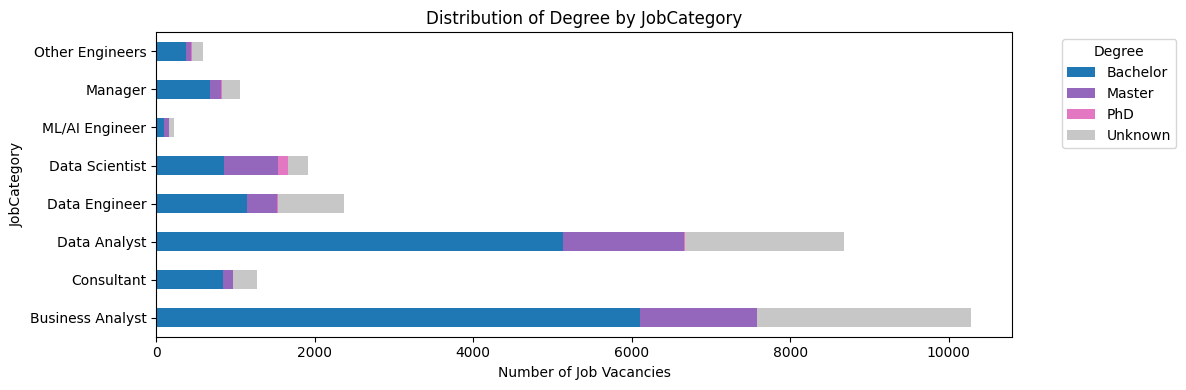

In [663]:
category_degree_distribution.plot(
    kind='barh',
    stacked=True,
    figsize=(12, 4),
    color=[experience_colors.get(d) for d in category_degree_distribution.columns]
)

plt.title("Distribution of Degree by JobCategory")
plt.xlabel("Number of Job Vacancies")
plt.ylabel("JobCategory")
plt.legend(title="Degree", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


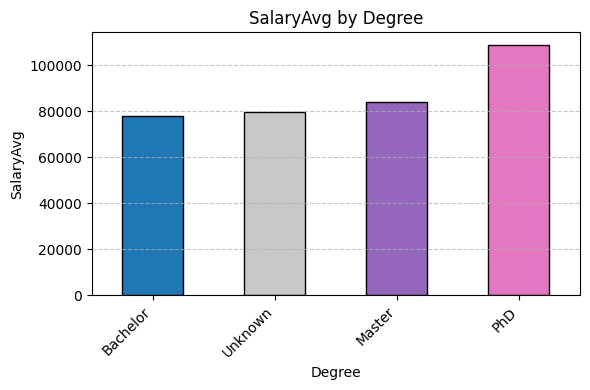

In [664]:
average_salary_by_degree = df.groupby('Degree')['SalaryAvg'].mean().sort_values()

plt.figure(figsize=(6, 4))
average_salary_by_degree.plot(kind='bar', color=[experience_colors.get(degree, 'gray') for degree in average_salary_by_degree.index], edgecolor='black')

plt.title("SalaryAvg by Degree")
plt.xlabel("Degree")
plt.ylabel("SalaryAvg")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [665]:
df.head(1)

Job Title  \
0  business analyst - clinical & logistics platform   

                               JobDescriptionCleaned  Rating  \
0  company overview memorial sloan kettering msk ...     3.9   

                    Company Name      Location  Headquarters  \
0  Memorial Sloan-Kettering\n3.9  New York, NY  New York, NY   

               Size       Type of ownership                          Industry  \
0  10000+ employees  Nonprofit Organization  Health Care Services & Hospitals   

        Sector                 Revenue  SalaryAvg       JobCategory  Python  \
0  Health Care  $2 to $5 billion (USD)    79000.0  Business Analyst       0   

   Spark ExperienceLevel    Degree  
0      0         Unknown  Bachelor

Other categorical features

*Company Name*

In [666]:
print(df['Company Name'].unique())
df['Company Name'] = df['Company Name'].apply(lambda x: re.sub(r'\n?\d+\.\d+$', '', x))
df['Company Name'] = df['Company Name'].str.lower()
print(df['Company Name'].unique())


['Memorial Sloan-Kettering\n3.9' 'Paine Schwartz Partners\n3.8'
 'Asembia\n3.6' ... 'Huntington Bancshares Inc\n3.5' 'DATAECONOMY\n5.0'
 'Data Resource Technologies\n4.0']
['memorial sloan-kettering' 'paine schwartz partners' 'asembia' ...
 'huntington bancshares inc' 'dataeconomy' 'data resource technologies']


In [667]:
df['Company Name'] = df['Company Name'].replace(['-1'], 'Unknown')
unique_feature = df['Company Name'].nunique()
print(unique_feature)
# print(df['Company Name'].value_counts().head())
print(df['Company Name'].isin(['Unknown']).sum())
# print(df['Company Name'].value_counts().tail())

7635
0


In [668]:
categories = df['Company Name'].unique()
palette = sns.color_palette('hls', len(categories))
palette_dict = {category: palette[i] for i, category in enumerate(categories)}

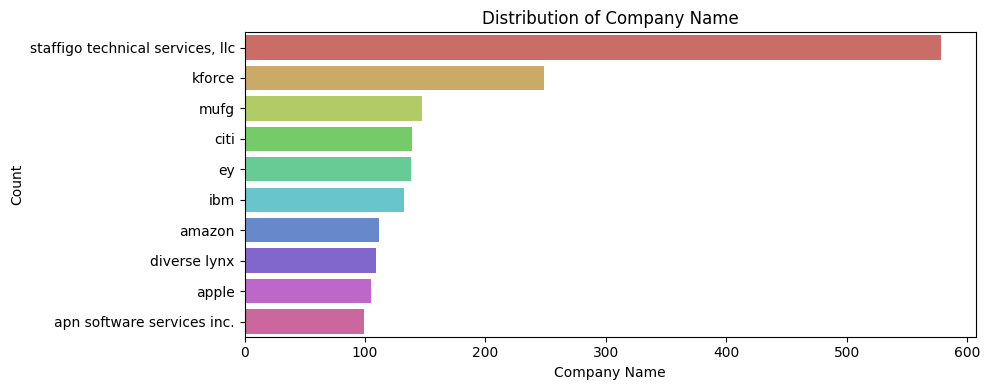

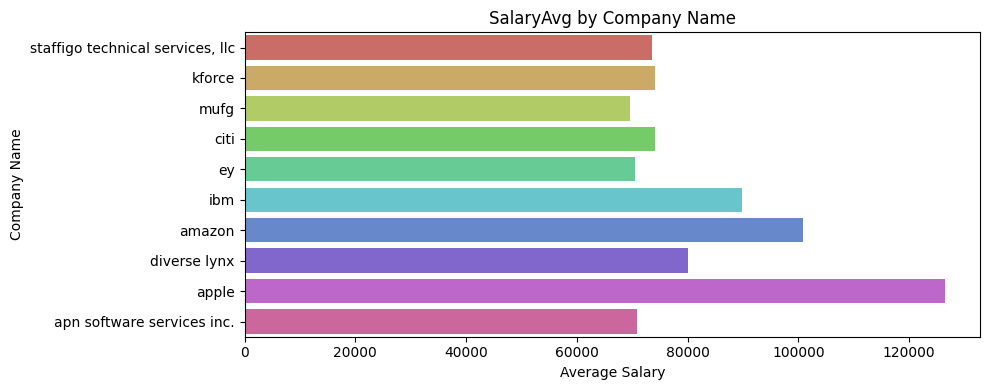

In [669]:
filtered_category = df[df['Company Name'] != 'Unknown']

company_counts = filtered_category['Company Name'].value_counts()

top_company_count = company_counts.head(10)
categories = top_company_count.index
palette = sns.color_palette('hls', len(categories))
palette_dict = {category: palette[i] for i, category in enumerate(categories)}

plt.figure(figsize=(10, 4))
sns.barplot(y=top_company_count.index, x=top_company_count.values, hue=top_company_count.index, legend=False, palette=palette_dict)
plt.title('Distribution of Company Name')
plt.xlabel('Company Name')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

category_salary_avg = filtered_category.groupby('Company Name')['SalaryAvg'].mean()

top_salary_avg = category_salary_avg.loc[top_company_count.index]

plt.figure(figsize=(10, 4))
sns.barplot(y=top_salary_avg.index, x=top_salary_avg.values, hue=top_salary_avg.index, legend=False, palette=palette_dict)
plt.xlabel('Average Salary')
plt.ylabel('Company Name')
plt.title('SalaryAvg by Company Name')
plt.tight_layout()
plt.show()


*Location*

In [671]:
unique_feature = df['Location'].nunique()
print(unique_feature)
print(df['Location'].value_counts().head(10))

871
Location
New York, NY        2090
Houston, TX         1874
Chicago, IL         1866
Austin, TX          1550
San Diego, CA       1397
Los Angeles, CA     1264
Phoenix, AZ         1124
Dallas, TX           953
Jacksonville, FL     941
San Antonio, TX      861
Name: count, dtype: int64


In [672]:
def extract_city_state(location):
    parts = location.split(',')

    if len(parts) == 2:
        city, state = parts[0].strip(), parts[1].strip()
        if len(state) == 2:
            return city, state
        else:
            return city, "Unknown"

    elif len(parts) == 3:
        city = parts[0].strip()
        state = parts[2].strip()
        return city, state

    else:
        city = parts[0].strip()
        state = "Unknown"
        return city, state

df[['City', 'State']] = df['Location'].apply(lambda x: pd.Series(extract_city_state(x)))
df = df.drop(columns=['Location'])
df.head(1)

Job Title  \
0  business analyst - clinical & logistics platform   

                               JobDescriptionCleaned  Rating  \
0  company overview memorial sloan kettering msk ...     3.9   

               Company Name  Headquarters              Size  \
0  memorial sloan-kettering  New York, NY  10000+ employees   

        Type of ownership                          Industry       Sector  \
0  Nonprofit Organization  Health Care Services & Hospitals  Health Care   

                  Revenue  SalaryAvg       JobCategory  Python  Spark  \
0  $2 to $5 billion (USD)    79000.0  Business Analyst       0      0   

  ExperienceLevel    Degree      City State  
0         Unknown  Bachelor  New York    NY

In [673]:
unique_feature = df['City'].nunique()
print(unique_feature)
unique_feature = df['State'].nunique()
print(unique_feature)

833
39


In [674]:
df['State'].isnull().sum()

0

In [675]:
df[df['State'] == 'Unknown'][['State', 'City']]

State           City
14330  Unknown         Remote
14331  Unknown         Canada
14332  Unknown  United States
14333  Unknown         Remote
14334  Unknown         Remote
...        ...            ...
16014  Unknown  United States
25552  Unknown      Stevenage
25632  Unknown      Stevenage
25644  Unknown      Brentford
25690  Unknown      Brentford

[246 rows x 2 columns]

In [676]:
valid_cities = ['us', 'usa', 'united states']
valid_cities += df[df['State'] != 'Unknown']['City'].str.lower().unique().tolist()
print(valid_cities)
def clean_city_state(row):
    if row['State'] == 'Unknown':
        if row['City'].lower() in valid_cities:
            row['City'] = 'Unknown'
        else:
            return None
    return row

df = df.apply(clean_city_state, axis=1).dropna(subset=['City', 'State'])

['us', 'usa', 'united states', 'new york', 'florham park', 'franklin lakes', 'lyndhurst', 'jersey city', 'newark', 'brooklyn', 'hackensack', 'iselin', 'whippany', 'hoboken', 'weehawken', 'moonachie', 'teaneck', 'rego park', 'paramus', 'livingston', 'secaucus', 'south plainfield', 'madison', 'ridgefield park', 'harrison', 'lake hiawatha', 'woodbridge', 'union', 'summit', 'rutherford', 'matawan', 'wilmington', 'los angeles', 'santa monica', 'el segundo', 'glendale', 'long beach', 'commerce', 'hollywood', 'west covina', 'inglewood', 'calabasas', 'anaheim', 'brea', 'marina del rey', 'burbank', 'rosemead', 'cerritos', 'pasadena', 'torrance', 'westminster', 'el monte', 'monterey park', 'hawthorne', 'beverly hills', 'culver city', 'irwindale', 'signal hill', 'redondo beach', 'gardena', 'city of industry', 'bell', 'alhambra', 'manhattan beach', 'la palma', 'sylmar', 'fullerton', 'buena park', 'la mirada', 'whittier', 'duarte', 'santa fe springs', 'woodland hills', 'artesia', 'west hills', 'sea

In [677]:
df[df['State'] == 'Unknown'][['State', 'City']].head(5)

State     City
14332  Unknown  Unknown
14336  Unknown  Unknown
14338  Unknown  Unknown
14339  Unknown  Unknown
14340  Unknown  Unknown

In [678]:
unique_feature = df['City'].nunique()
print(unique_feature)
unique_feature = df['State'].nunique()
print(unique_feature)

806
39


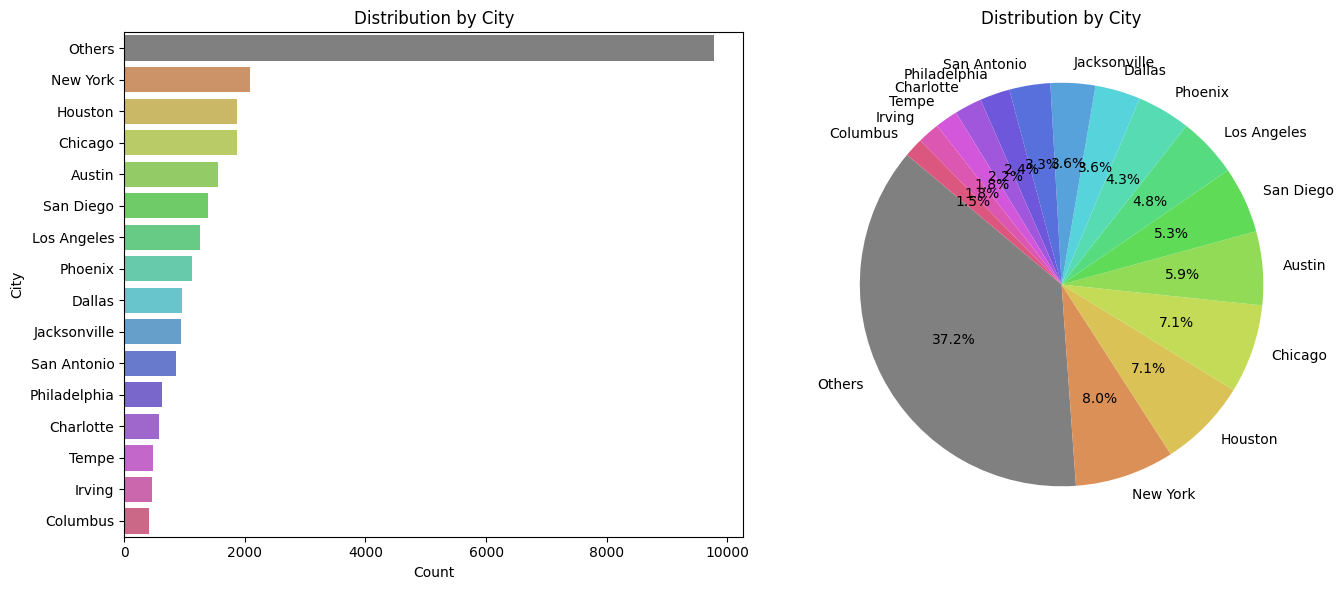

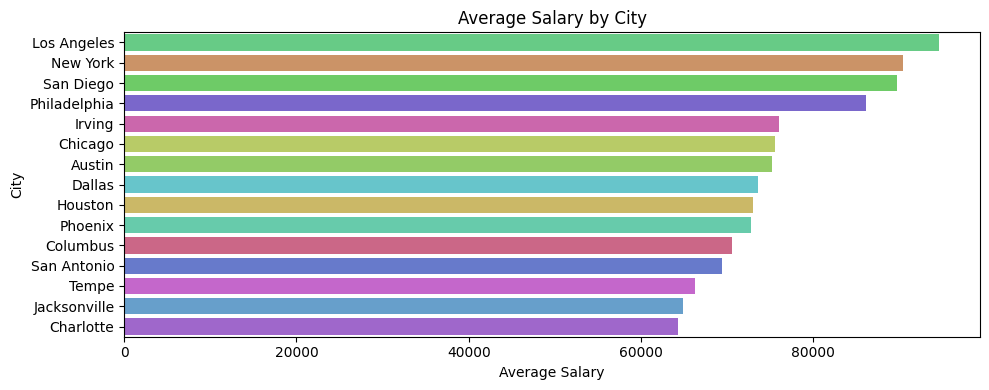

In [679]:
filtered_category = df['City']
category_counts = filtered_category.value_counts()

total_count = category_counts.sum()
threshold = 0.015 * total_count

filtered_category_updated = filtered_category.where(filtered_category.isin(category_counts[category_counts > threshold].index), 'Others')
category_counts_updated = filtered_category_updated.value_counts()

categories_updated = category_counts_updated.index
palette = sns.color_palette('hls', len(categories_updated))
palette_dict_others = {category: palette[i] for i, category in enumerate(categories_updated)}
palette_dict_others['Others'] = 'gray'

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(y=category_counts_updated.index, x=category_counts_updated.values, hue = category_counts_updated.index, legend = False, palette=palette_dict_others)
plt.title('Distribution by City')
plt.xlabel('Count')
plt.ylabel('City')

plt.subplot(1, 2, 2)
plt.pie(category_counts_updated.values, labels=category_counts_updated.index, autopct='%1.1f%%', startangle=140,
        colors=[palette_dict_others.get(category, 'gray') for category in category_counts_updated.index])
plt.title('Distribution by City')
plt.tight_layout()
plt.show()

category_salary_avg = df.groupby('City')['SalaryAvg'].mean()
filtered_salary_avg = category_salary_avg[category_salary_avg.index.isin(category_counts_updated.index)].sort_values(ascending=False)
plt.figure(figsize=(10, 4))
sns.barplot(y=filtered_salary_avg.index, x=filtered_salary_avg.values, hue = filtered_salary_avg.index, legend = False, palette=palette_dict_others)
plt.xlabel('Average Salary')
plt.ylabel('City')
plt.title('Average Salary by City')
plt.tight_layout()
plt.show()


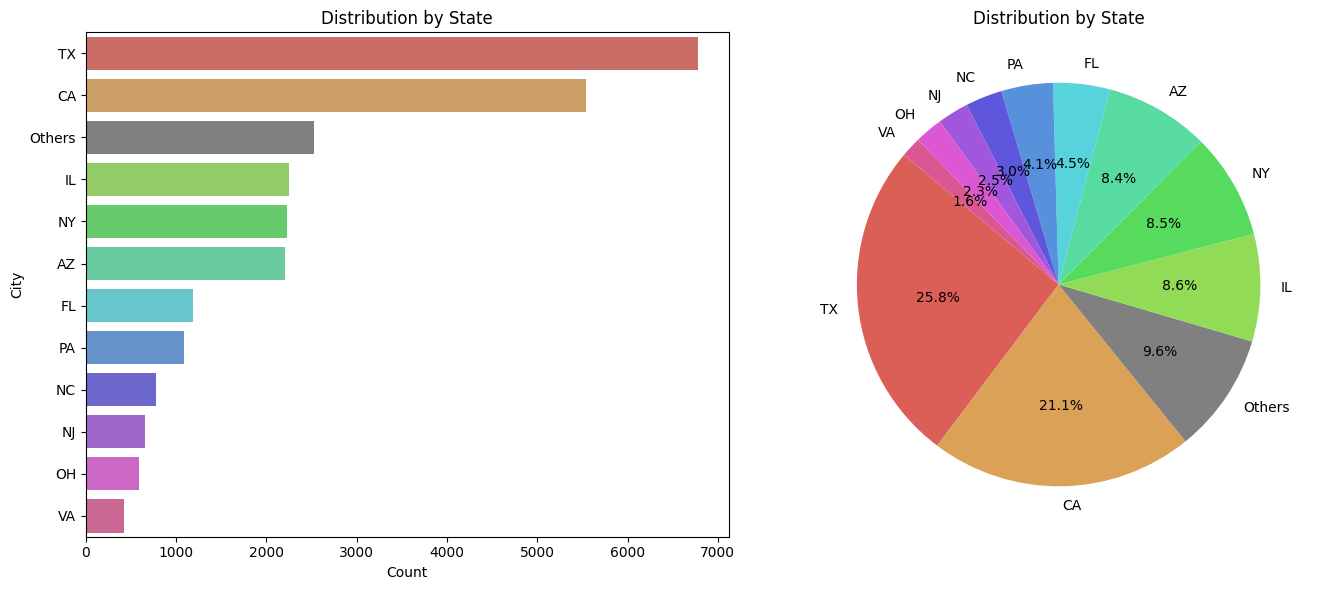

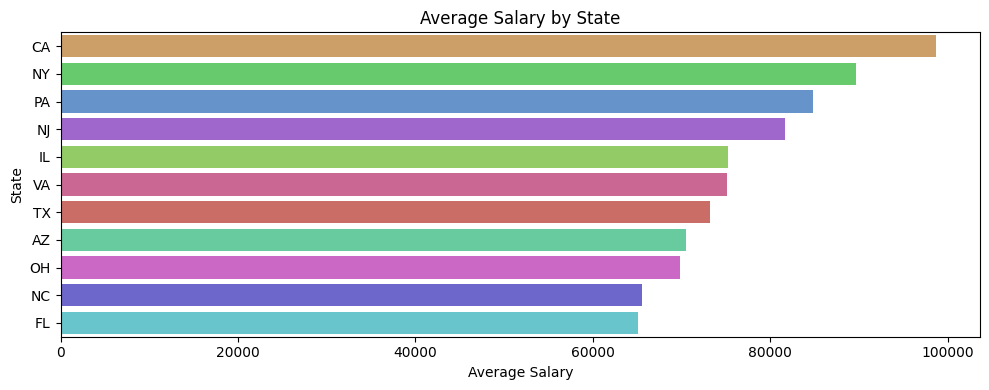

In [680]:
filtered_category = df['State']
category_counts = filtered_category.value_counts()

total_count = category_counts.sum()
threshold = 0.015 * total_count

filtered_category_updated = filtered_category.where(filtered_category.isin(category_counts[category_counts > threshold].index), 'Others')
category_counts_updated = filtered_category_updated.value_counts()

categories_updated = category_counts_updated.index
palette = sns.color_palette('hls', len(categories_updated))
palette_dict_others = {category: palette[i] for i, category in enumerate(categories_updated)}
palette_dict_others['Others'] = 'gray'

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(y=category_counts_updated.index, x=category_counts_updated.values, hue = category_counts_updated.index, legend = False, palette=palette_dict_others)
plt.title('Distribution by State')
plt.xlabel('Count')
plt.ylabel('City')

plt.subplot(1, 2, 2)
plt.pie(category_counts_updated.values, labels=category_counts_updated.index, autopct='%1.1f%%', startangle=140,
        colors=[palette_dict_others.get(category, 'gray') for category in category_counts_updated.index])
plt.title('Distribution by State')
plt.tight_layout()
plt.show()

category_salary_avg = df.groupby('State')['SalaryAvg'].mean()
filtered_salary_avg = category_salary_avg[category_salary_avg.index.isin(category_counts_updated.index)].sort_values(ascending=False)
plt.figure(figsize=(10, 4))
sns.barplot(y=filtered_salary_avg.index, x=filtered_salary_avg.values, hue = filtered_salary_avg.index, legend = False, palette=palette_dict_others)
plt.xlabel('Average Salary')
plt.ylabel('State')
plt.title('Average Salary by State')
plt.tight_layout()
plt.show()


*Headquarters*

In [681]:
df['Headquarters'] = df['Headquarters'].replace(['-1'], 'Unknown')
unique_feature = df['Headquarters'].nunique()
print(unique_feature)
print(df['Headquarters'].value_counts().head(10))

1367
Headquarters
New York, NY         1943
Unknown              1313
Chicago, IL           985
San Diego, CA         774
Houston, TX           748
Los Angeles, CA       639
Woodridge, IL         578
Austin, TX            438
San Francisco, CA     427
Dallas, TX            387
Name: count, dtype: int64


In [682]:
def extract_city_state(location):
    parts = location.split(',')

    if len(parts) == 2:
        city, state = parts[0].strip(), parts[1].strip()
        if len(state) == 2:
            return city, state
        else:
            return city, "Unknown"

    elif len(parts) == 3:
        city = parts[0].strip()
        state = parts[2].strip()
        return city, state

    else:
        city = parts[0].strip()
        state = "Unknown"
        return city, state

df[['HeadquartersCity', 'HeadquartersState']] = df['Headquarters'].apply(lambda x: pd.Series(extract_city_state(x)))
df = df.drop(columns=['Headquarters'])
df.head(1)

Job Title  \
0  business analyst - clinical & logistics platform   

                               JobDescriptionCleaned  Rating  \
0  company overview memorial sloan kettering msk ...     3.9   

               Company Name              Size       Type of ownership  \
0  memorial sloan-kettering  10000+ employees  Nonprofit Organization   

                           Industry       Sector                 Revenue  \
0  Health Care Services & Hospitals  Health Care  $2 to $5 billion (USD)   

   SalaryAvg       JobCategory  Python  Spark ExperienceLevel    Degree  \
0    79000.0  Business Analyst     0.0    0.0         Unknown  Bachelor   

       City State HeadquartersCity HeadquartersState  
0  New York    NY         New York                NY

In [683]:
unique_feature = df['HeadquartersCity'].nunique()
print(unique_feature)
unique_feature = df['HeadquartersState'].nunique()
print(unique_feature)

1268
54


In [684]:
df['HeadquartersState'].isnull().sum()

0

In [685]:
df[df['HeadquartersState'] == 'Unknown'][['HeadquartersState', 'HeadquartersCity']]

HeadquartersState HeadquartersCity
6               Unknown           Zurich
14              Unknown           London
15              Unknown        Amsterdam
24              Unknown           London
28              Unknown            Tokyo
...                 ...              ...
26958           Unknown          Unknown
26962           Unknown          Chennai
26968           Unknown          Brussel
26969           Unknown          Brussel
26979           Unknown          Brussel

[3400 rows x 2 columns]

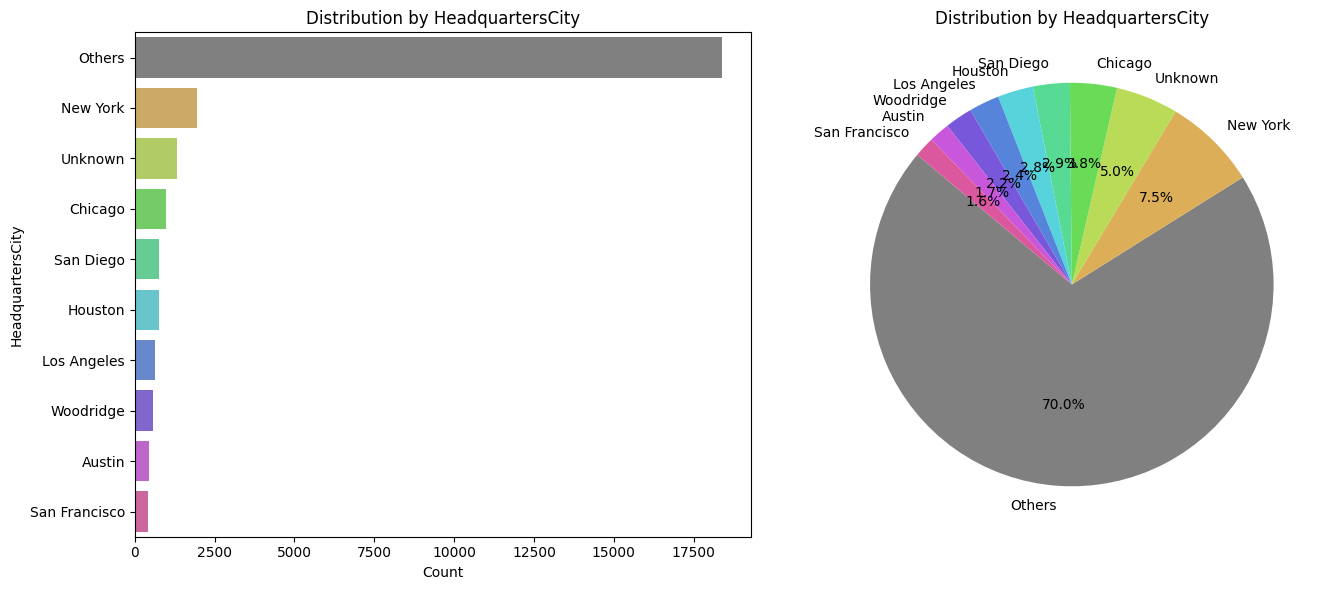

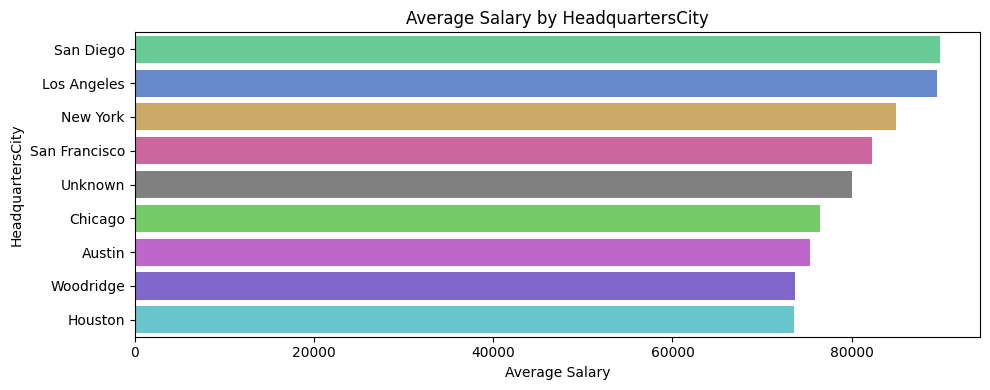

In [686]:
filtered_category = df['HeadquartersCity']
category_counts = filtered_category.value_counts()

total_count = category_counts.sum()
threshold = 0.015 * total_count

filtered_category_updated = filtered_category.where(filtered_category.isin(category_counts[category_counts > threshold].index), 'Others')
category_counts_updated = filtered_category_updated.value_counts()

categories_updated = category_counts_updated.index
palette = sns.color_palette('hls', len(categories_updated))
palette_dict_others = {category: palette[i] for i, category in enumerate(categories_updated)}
palette_dict_others['Others'] = 'gray'

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(y=category_counts_updated.index, x=category_counts_updated.values, hue = category_counts_updated.index, legend = False, palette=palette_dict_others)
plt.title('Distribution by HeadquartersCity')
plt.xlabel('Count')
plt.ylabel('HeadquartersCity')

plt.subplot(1, 2, 2)
plt.pie(category_counts_updated.values, labels=category_counts_updated.index, autopct='%1.1f%%', startangle=140,
        colors=[palette_dict_others.get(category, 'gray') for category in category_counts_updated.index])
plt.title('Distribution by HeadquartersCity')
plt.tight_layout()
plt.show()

category_salary_avg = df.groupby('HeadquartersCity')['SalaryAvg'].mean()
filtered_salary_avg = category_salary_avg[category_salary_avg.index.isin(category_counts_updated.index)].sort_values(ascending=False)
plt.figure(figsize=(10, 4))
palette_dict_others['Unknown'] = 'gray'
sns.barplot(y=filtered_salary_avg.index, x=filtered_salary_avg.values, hue = filtered_salary_avg.index, legend = False, palette=palette_dict_others)
plt.xlabel('Average Salary')
plt.ylabel('HeadquartersCity')
plt.title('Average Salary by HeadquartersCity')
plt.tight_layout()
plt.show()


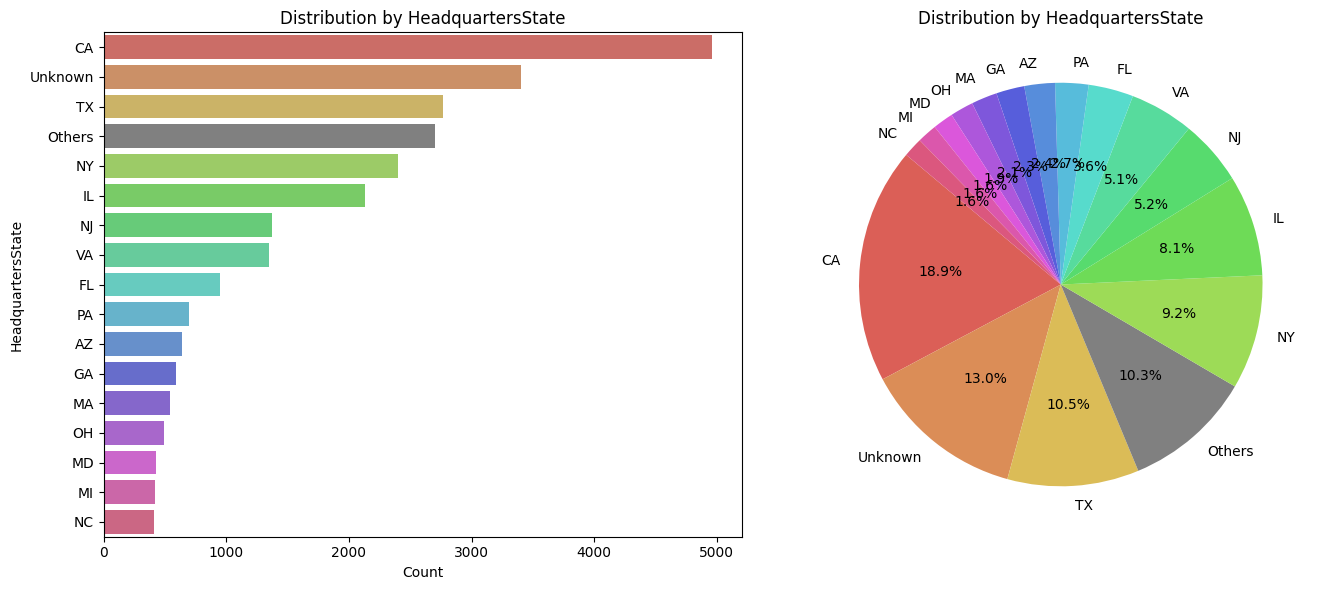

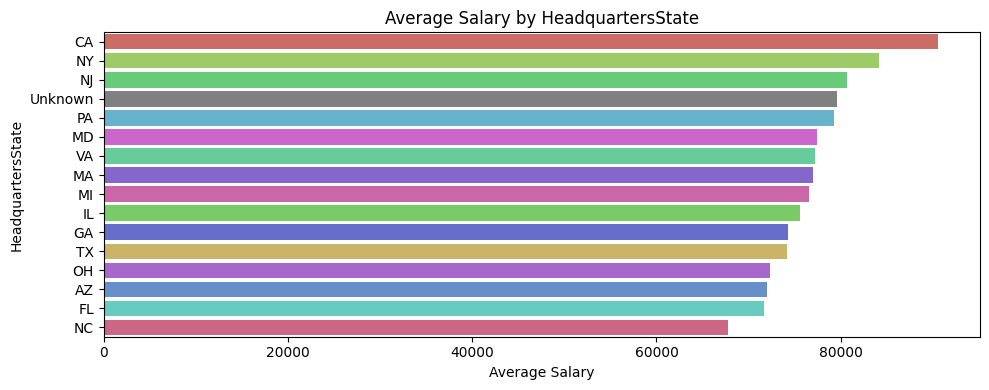

In [687]:
filtered_category = df['HeadquartersState']
category_counts = filtered_category.value_counts()

total_count = category_counts.sum()
threshold = 0.015 * total_count

filtered_category_updated = filtered_category.where(filtered_category.isin(category_counts[category_counts > threshold].index), 'Others')
category_counts_updated = filtered_category_updated.value_counts()

categories_updated = category_counts_updated.index
palette = sns.color_palette('hls', len(categories_updated))
palette_dict_others = {category: palette[i] for i, category in enumerate(categories_updated)}
palette_dict_others['Others'] = 'gray'

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(y=category_counts_updated.index, x=category_counts_updated.values, hue = category_counts_updated.index, legend = False, palette=palette_dict_others)
plt.title('Distribution by HeadquartersState')
plt.xlabel('Count')
plt.ylabel('HeadquartersState')

plt.subplot(1, 2, 2)
plt.pie(category_counts_updated.values, labels=category_counts_updated.index, autopct='%1.1f%%', startangle=140,
        colors=[palette_dict_others.get(category, 'gray') for category in category_counts_updated.index])
plt.title('Distribution by HeadquartersState')
plt.tight_layout()
plt.show()

category_salary_avg = df.groupby('HeadquartersState')['SalaryAvg'].mean()
filtered_salary_avg = category_salary_avg[category_salary_avg.index.isin(category_counts_updated.index)].sort_values(ascending=False)
plt.figure(figsize=(10, 4))
palette_dict_others['Unknown'] = 'gray'
sns.barplot(y=filtered_salary_avg.index, x=filtered_salary_avg.values, hue = filtered_salary_avg.index, legend = False, palette=palette_dict_others)
plt.xlabel('Average Salary')
plt.ylabel('HeadquartersState')
plt.title('Average Salary by HeadquartersState')
plt.tight_layout()
plt.show()


*Size*

In [688]:
df['Size'] = df['Size'].replace(['-1', 'Unknown'], 'Unknown')
unique_feature = df['Size'].nunique()
print(unique_feature)
print(df['Size'].value_counts().head(10))

8
Size
10000+ employees           6310
1001 to 5000 employees     4415
51 to 200 employees        4365
1 to 50 employees          3175
201 to 500 employees       2551
501 to 1000 employees      2073
Unknown                    1776
5001 to 10000 employees    1583
Name: count, dtype: int64


In [689]:
categories = df['Size'].unique()
palette = sns.color_palette('hls', len(categories))
palette_dict = {category: palette[i] for i, category in enumerate(categories)}

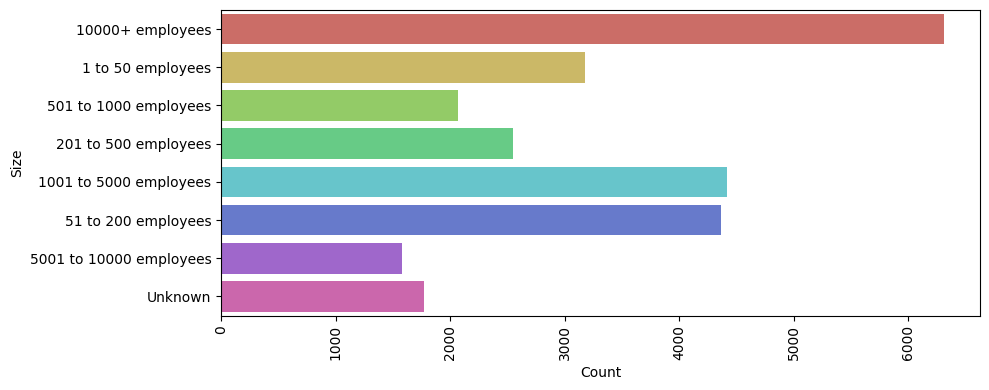

In [690]:
plt.figure(figsize=(10, 4))
sns.countplot(y='Size', data=df, hue = 'Size', legend = False, palette=palette_dict)
plt.xticks(rotation=90)
plt.ylabel('Size')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

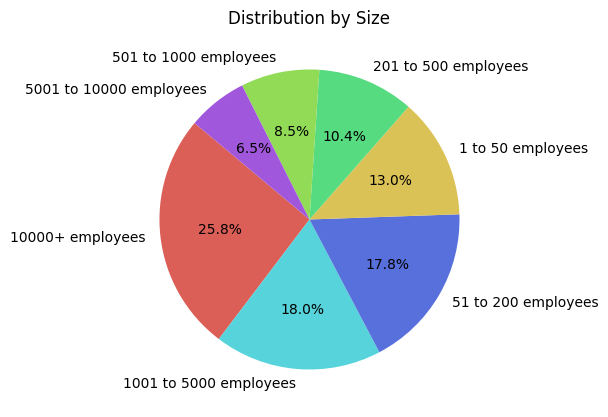

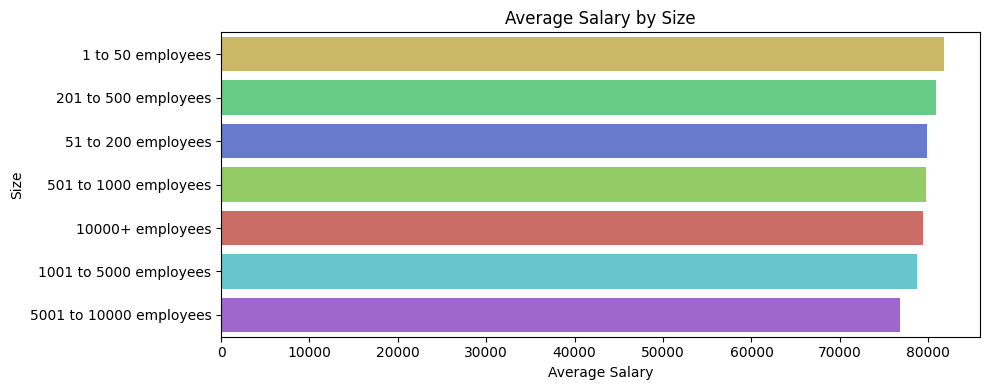

In [691]:
filtered_size = df[df['Size'] != 'Unknown']
size_counts = filtered_size['Size'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(size_counts.values, labels=size_counts.index, autopct='%1.1f%%', startangle=140,
        colors=[palette_dict[category] for category in size_counts.index])

plt.title('Distribution by Size')
plt.tight_layout()
plt.show()

category_salary_avg = filtered_size.groupby('Size')['SalaryAvg'].mean().sort_values(ascending=False)
# print("Average Salary for Revenue:")
# print(category_salary_avg)

plt.figure(figsize=(10, 4))
sns.barplot(y=category_salary_avg.index, x=category_salary_avg.values, hue=category_salary_avg.index, legend=False, palette=palette_dict)
plt.xlabel('Average Salary')
plt.ylabel('Size')
plt.title('Average Salary by Size')
plt.tight_layout()
plt.show()


*Type of ownership*

In [692]:
df['Type of ownership'] = df['Type of ownership'].replace(['-1'], 'Unknown')
unique_feature = df['Type of ownership'].nunique()
print(unique_feature)
print(df['Type of ownership'].value_counts().head(15))

14
Type of ownership
Company - Private                 13605
Company - Public                   7386
Unknown                            1452
Subsidiary or Business Segment     1137
Nonprofit Organization             1094
Government                          640
College / University                326
Hospital                            163
Contract                            134
Private Practice / Firm             111
Other Organization                   93
School / School District             75
Franchise                            17
Self-employed                        15
Name: count, dtype: int64


In [693]:
categories = df['Type of ownership'].unique()
palette = sns.color_palette('hls', len(categories))
palette_dict = {category: palette[i] for i, category in enumerate(categories)}

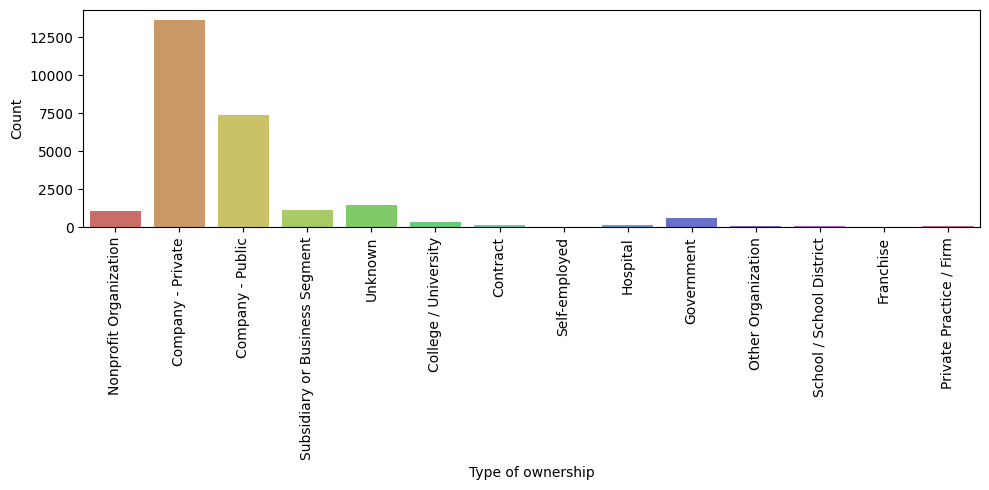

In [694]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Type of ownership', data=df, hue = 'Type of ownership', legend = False, palette=palette_dict)
plt.xticks(rotation=90)
plt.xlabel('Type of ownership')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

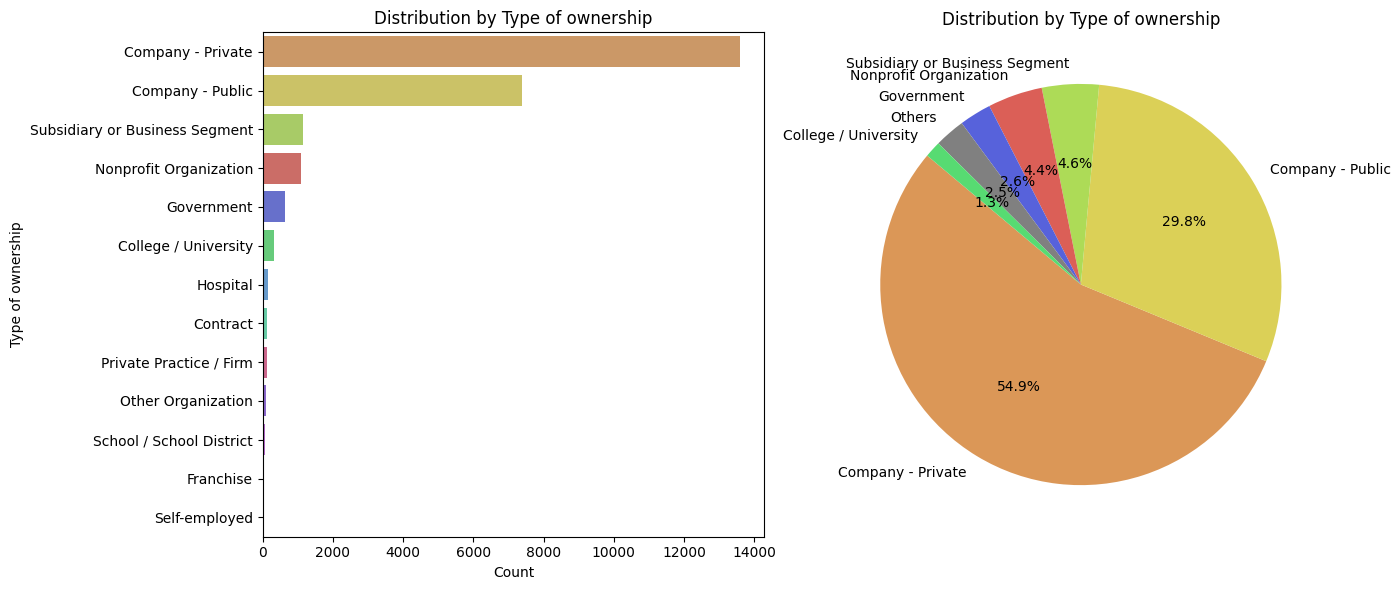

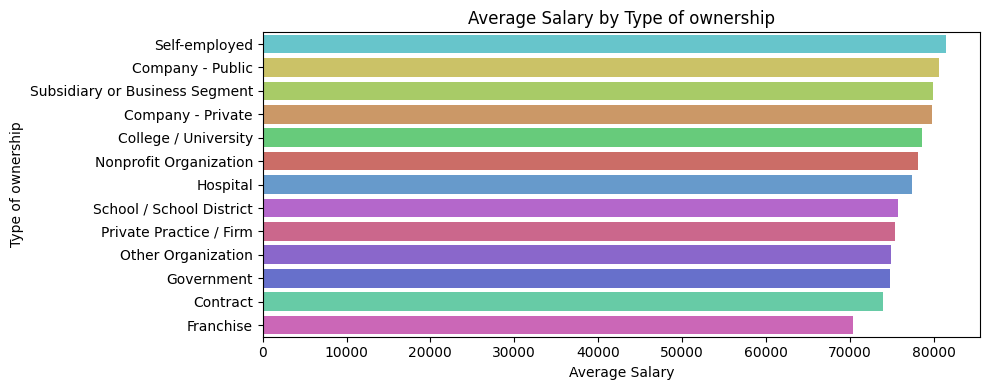

In [695]:
filtered_category = df[df['Type of ownership'] != 'Unknown']
category_counts = filtered_category['Type of ownership'].value_counts()

total_count = category_counts.sum()
threshold = 0.01 * total_count

filtered_category_updated=filtered_category.copy()
others = category_counts[category_counts < threshold].index
filtered_category_updated['Type of ownership'] = filtered_category_updated['Type of ownership'].replace(others, 'Others')
category_counts_updated = filtered_category_updated['Type of ownership'].value_counts()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(y=category_counts.index, x=category_counts.values, hue = category_counts.index, legend = False,
            palette=palette_dict)
plt.title('Distribution by Type of ownership')
plt.xlabel('Count')
plt.ylabel('Type of ownership')

# category_counts_filtered = category_counts_updated[category_counts_updated > 300]
palette_dict_others=palette_dict.copy()
palette_dict_others['Others'] = 'gray'
plt.subplot(1, 2, 2)
plt.pie(category_counts_updated.values, labels=category_counts_updated.index, autopct='%1.1f%%', startangle=140,
        colors=[palette_dict_others.get(category, 'gray') for category in category_counts_updated.index])
plt.title('Distribution by Type of ownership')

plt.tight_layout()
plt.show()
#
category_salary_avg = filtered_category.groupby('Type of ownership')['SalaryAvg'].mean().sort_values(ascending=False)
# print("Average Salary for Revenue:")
# print(category_salary_avg)

plt.figure(figsize=(10, 4))
sns.barplot(y=category_salary_avg.index, x=category_salary_avg.values, hue=category_salary_avg.index, legend=False, palette=palette_dict)
plt.xlabel('Average Salary')
plt.ylabel('Type of ownership')
plt.title('Average Salary by Type of ownership')
plt.tight_layout()
plt.show()


*Sector*

In [696]:
df['Sector'] = df['Sector'].replace(['-1'], 'Unknown')

unique_salaries = df['Sector'].nunique()
print(unique_salaries)
print(df['Sector'].value_counts().head(26))



26
Sector
Information Technology                6571
Business Services                     5215
Unknown                               3297
Finance                               2439
Health Care                           1383
Insurance                              952
Manufacturing                          865
Biotech & Pharmaceuticals              656
Aerospace & Defense                    627
Government                             612
Accounting & Legal                     558
Retail                                 545
Education                              530
Oil, Gas, Energy & Utilities           393
Media                                  381
Transportation & Logistics             231
Non-Profit                             196
Real Estate                            191
Telecommunications                     173
Construction, Repair & Maintenance     139
Consumer Services                      127
Restaurants, Bars & Food Services       61
Travel & Tourism                        46
A

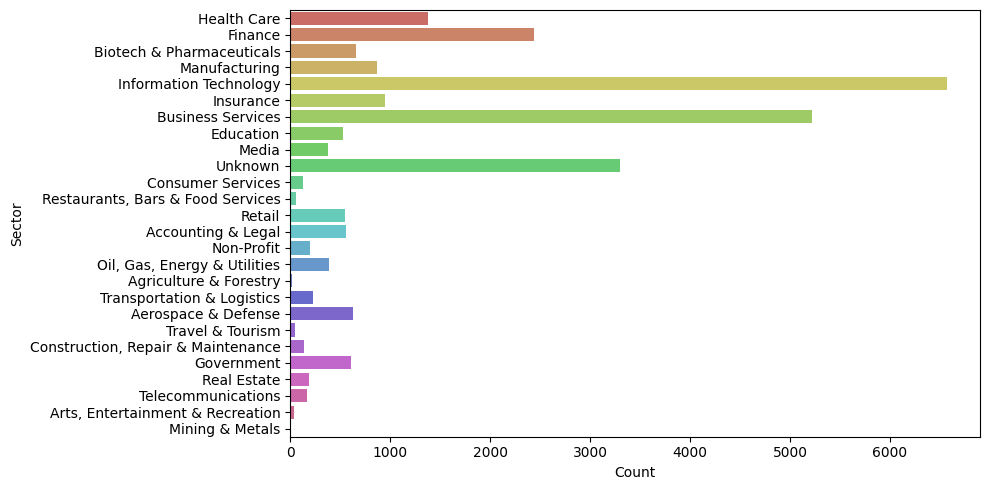

In [697]:
categories = df['Sector'].unique()
palette = sns.color_palette('hls', len(categories))
palette_dict = {category: palette[i] for i, category in enumerate(categories)}

plt.figure(figsize=(10, 5))
sns.countplot(y='Sector', data=df, hue='Sector', legend=False, palette=palette_dict)
plt.xlabel('Count')
plt.ylabel('Sector')
plt.tight_layout()
plt.show()

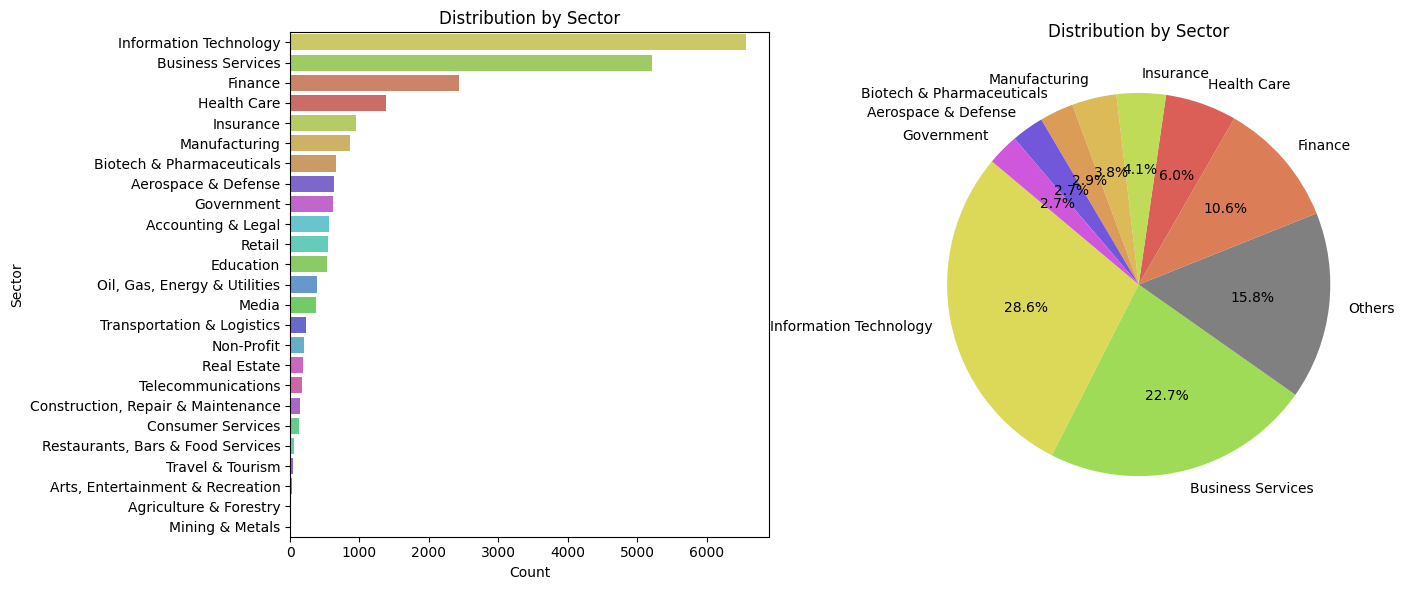

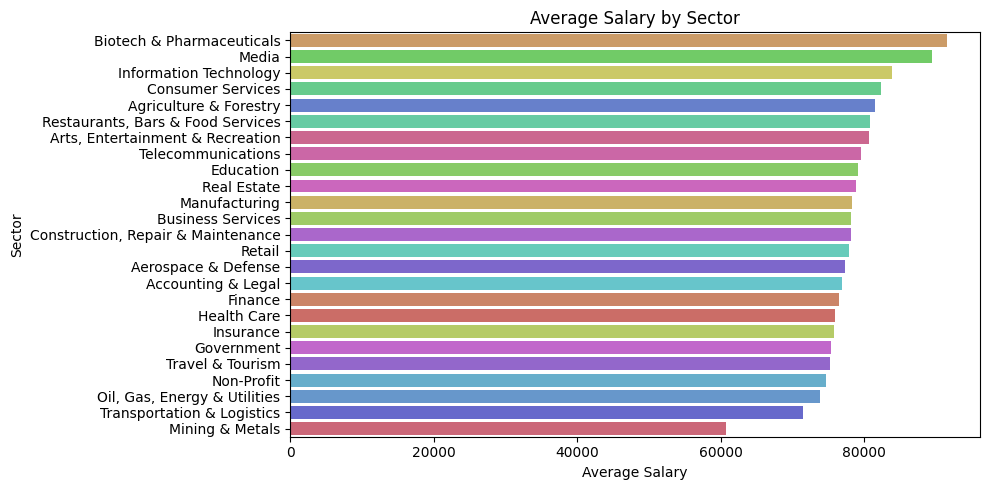

In [698]:
filtered_category = df[df['Sector'] != 'Unknown']
category_counts = filtered_category['Sector'].value_counts()

total_count = category_counts.sum()
threshold = 0.025 * total_count

filtered_category_updated=filtered_category.copy()
others = category_counts[category_counts <= threshold].index
filtered_category_updated['Sector'] = filtered_category_updated['Sector'].replace(others, 'Others')
category_counts_updated = filtered_category_updated['Sector'].value_counts()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(y=category_counts.index, x=category_counts.values, hue = category_counts.index, legend = False, palette=palette_dict)
plt.title('Distribution by Sector')
plt.xlabel('Count')
plt.ylabel('Sector')

# category_counts_filtered = category_counts_updated[category_counts_updated > 300]
palette_dict_others=palette_dict.copy()
palette_dict_others['Others'] = 'gray'
plt.subplot(1, 2, 2)
plt.pie(category_counts_updated.values, labels=category_counts_updated.index, autopct='%1.1f%%', startangle=140,
        colors=[palette_dict_others.get(category, 'gray') for category in category_counts_updated.index])
plt.title('Distribution by Sector')

plt.tight_layout()
plt.show()
#


category_salary_avg = filtered_category.groupby('Sector')['SalaryAvg'].mean().sort_values(ascending=False)
# print("Average Salary for Revenue:")
# print(category_salary_avg)

plt.figure(figsize=(10, 5))
sns.barplot(y=category_salary_avg.index, x=category_salary_avg.values, hue=category_salary_avg.index, legend=False, palette=palette_dict)
plt.xlabel('Average Salary')
plt.ylabel('Sector')
plt.title('Average Salary by Sector')
plt.tight_layout()
plt.show()


In [699]:
df['Industry'] = df['Industry'].replace(['-1'], 'Unknown')
unique_salaries = df['Industry'].nunique()
print(unique_salaries)
print(df['Industry'].value_counts().head(10))

122
Industry
IT Services                                3434
Unknown                                    3300
Staffing & Outsourcing                     2519
Consulting                                 1601
Computer Hardware & Software               1549
Health Care Services & Hospitals           1383
Investment Banking & Asset Management      1020
Enterprise Software & Network Solutions     877
Insurance Carriers                          846
Banks & Credit Unions                       767
Name: count, dtype: int64


In [700]:
filtered_sectors = ['Information Technology', 'Business Services', 'Finance', 'Health Care', 'Insurance', 'Manufacturing', 'Biotech & Pharmaceuticals', 'Media']
filtered_df = df[df['Sector'].isin(filtered_sectors)]
for sector in filtered_sectors:
    industries_in_sector = filtered_df[filtered_df['Sector'] == sector]['Industry'].unique()
    print(f"\nIndustries in {sector}:")
    print(industries_in_sector)



Industries in Information Technology:
['Internet' 'Computer Hardware & Software'
 'Enterprise Software & Network Solutions' 'IT Services' 'Unknown']

Industries in Business Services:
['Architectural & Engineering Services' 'Consulting'
 'Staffing & Outsourcing' 'Advertising & Marketing' 'Wholesale'
 'Building & Personnel Services' 'Research & Development'
 'Security Services' 'Membership Organizations'
 'Commercial Equipment Rental' 'Business Service Centers & Copy Shops']

Industries in Finance:
['Venture Capital & Private Equity'
 'Investment Banking & Asset Management'
 'Financial Transaction Processing' 'Lending' 'Banks & Credit Unions'
 'Stock Exchanges' 'Brokerage Services' 'Financial Analytics & Research']

Industries in Health Care:
['Health Care Services & Hospitals']

Industries in Insurance:
['Insurance Agencies & Brokerages' 'Insurance Carriers']

Industries in Manufacturing:
['Health Care Products Manufacturing' 'Food & Beverage Manufacturing'
 'Chemical Manufacturing' 'C

Information Technology


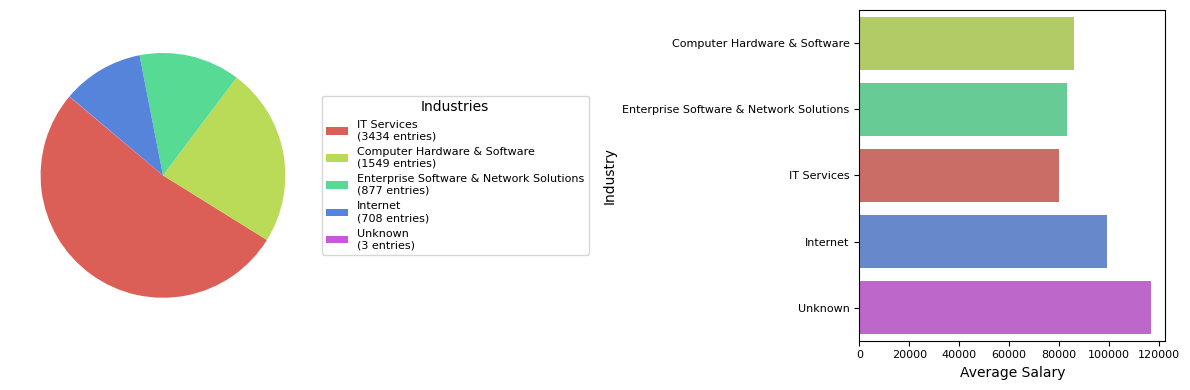

Business Services


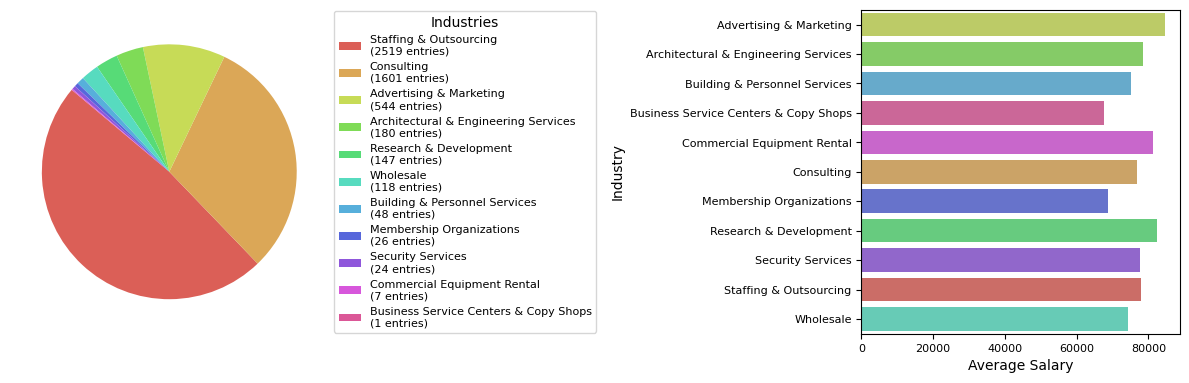

Finance


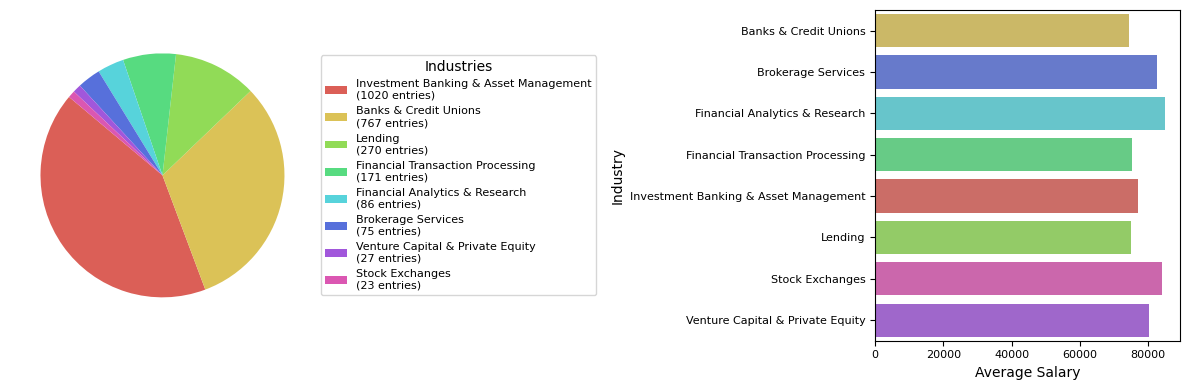

Insurance


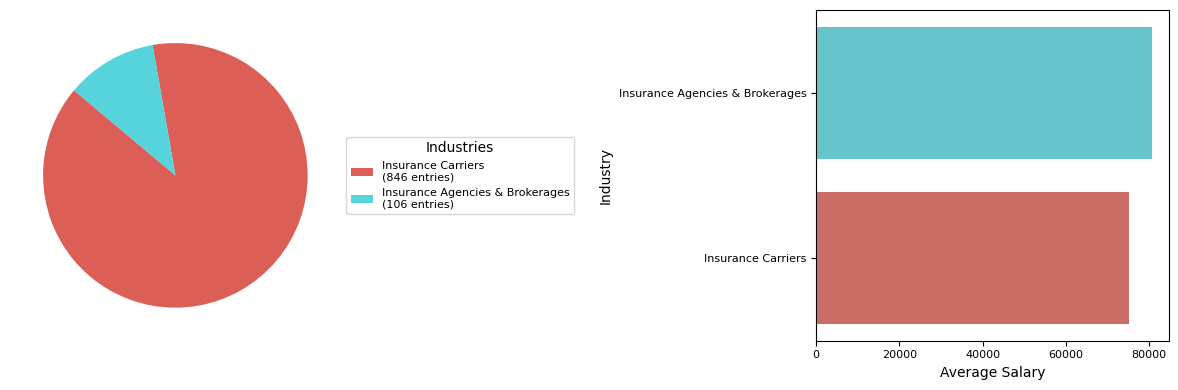

Manufacturing


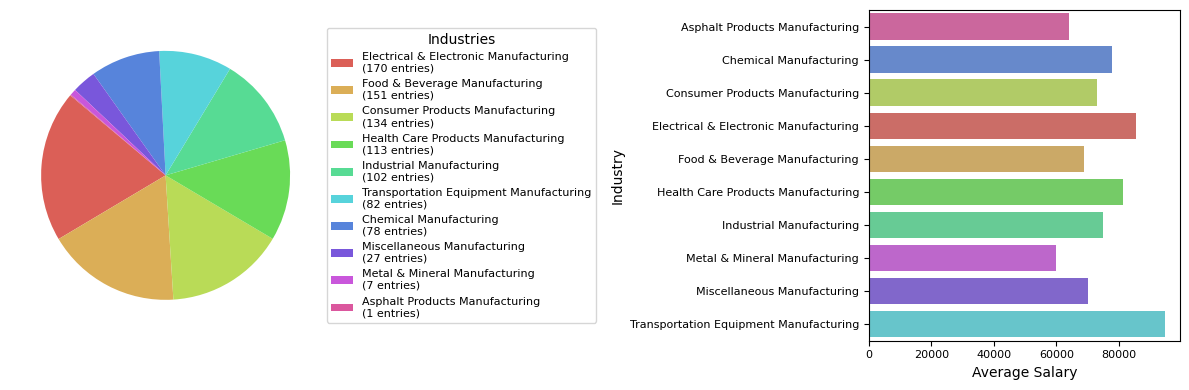

Media


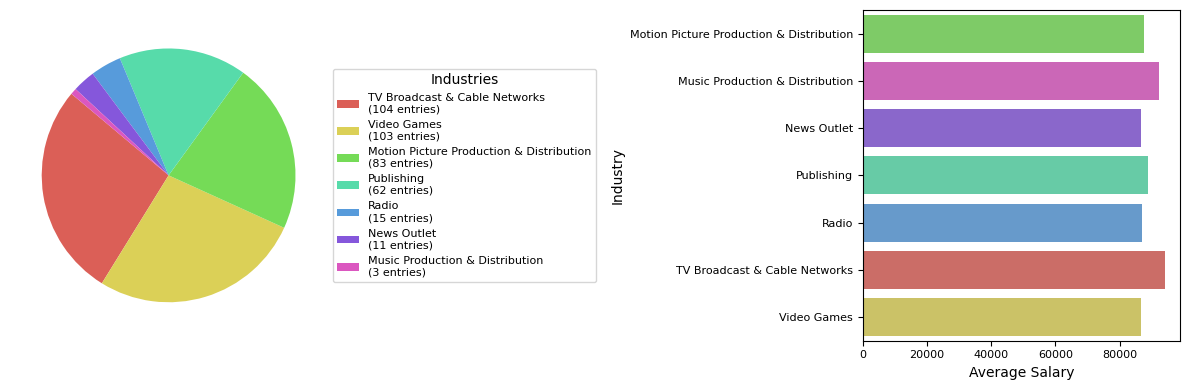

In [701]:
sectors_of_interest = ['Information Technology', 'Business Services', 'Finance', 'Insurance', 'Manufacturing', 'Media']

for sector in sectors_of_interest:
    print(f"{sector}")
    sector_df = df[df['Sector'] == sector]
    industry_counts = sector_df['Industry'].value_counts()
    avg_salary_by_industry = sector_df.groupby('Industry')['SalaryAvg'].mean()

    palette_dict = {industry: color for industry, color in zip(industry_counts.index, sns.color_palette("hls", len(industry_counts)))}

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    wedges, texts = plt.pie(industry_counts.values, labels=None, startangle=140,
                            colors=[palette_dict[industry] for industry in industry_counts.index])
    legend_labels = [
        f'{industry}\n({count} entries)'
        for industry, count in zip(industry_counts.index, industry_counts.values)
    ]
    plt.legend(wedges, legend_labels, title="Industries", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=8)

    plt.subplot(1, 2, 2)
    sns.barplot(x=avg_salary_by_industry.values, y=avg_salary_by_industry.index, hue=avg_salary_by_industry.index, palette=palette_dict)
    plt.xlabel('Average Salary')
    plt.ylabel('Industry')
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()


*Revenue*

In [702]:
df['Revenue'] = df['Revenue'].replace(['-1', 'Unknown / Non-Applicable'], 'Unknown')
unique_feature = df['Revenue'].nunique()
print(unique_feature)
print(df['Revenue'].value_counts().head(15))

13
Revenue
Unknown                             7742
$10+ billion (USD)                  3756
$100 to $500 million (USD)          2504
$50 to $100 million (USD)           1888
$2 to $5 billion (USD)              1626
$1 to $2 billion (USD)              1409
$10 to $25 million (USD)            1353
$25 to $50 million (USD)            1299
$1 to $5 million (USD)              1110
$5 to $10 billion (USD)             1012
$500 million to $1 billion (USD)    1004
$5 to $10 million (USD)              805
Less than $1 million (USD)           740
Name: count, dtype: int64


In [703]:
revenue_categories = df['Revenue'].unique()
palette = sns.color_palette('hls', len(revenue_categories))
palette_dict = {category: palette[i] for i, category in enumerate(revenue_categories)}

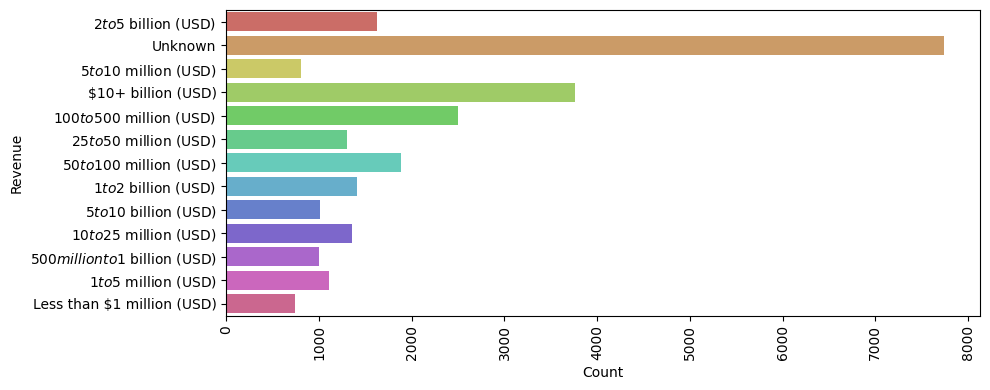

In [704]:
plt.figure(figsize=(10, 4))
sns.countplot(y='Revenue', data=df, hue = 'Revenue', legend = False, palette=palette_dict)
plt.xticks(rotation=90)
plt.ylabel('Revenue')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

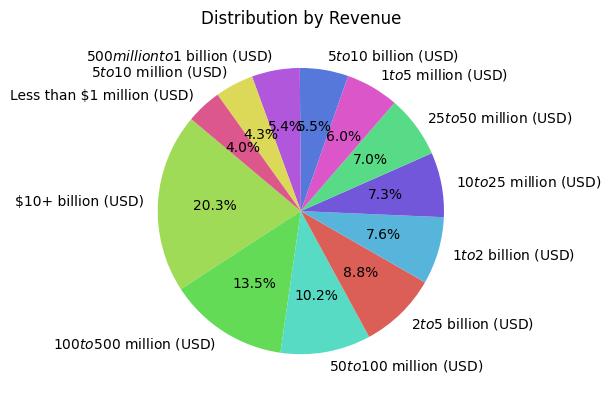

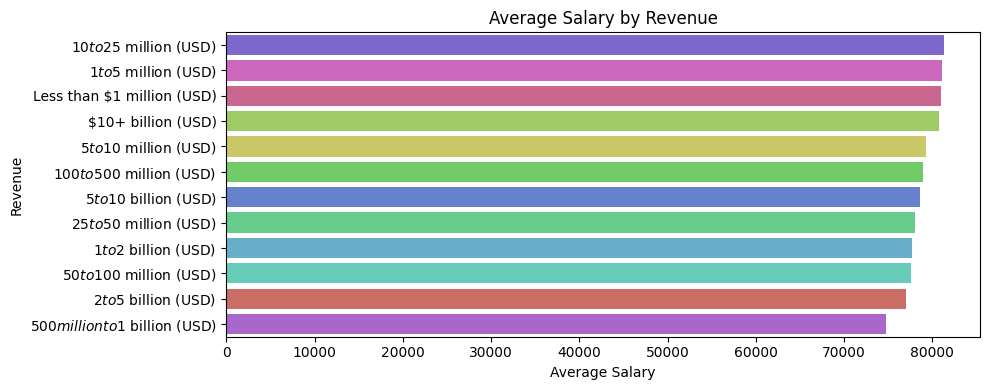

In [705]:
filtered_revenue = df[df['Revenue'] != 'Unknown']
revenue_counts = filtered_revenue['Revenue'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(revenue_counts.values, labels=revenue_counts.index, autopct='%1.1f%%', startangle=140, colors=[palette_dict[category] for category in revenue_counts.index])

plt.title('Distribution by Revenue')
plt.tight_layout()
plt.show()

category_salary_avg = filtered_revenue.groupby('Revenue')['SalaryAvg'].mean().sort_values(ascending=False)
# print("Average Salary for Revenue:")
# print(category_salary_avg)

plt.figure(figsize=(10, 4))
sns.barplot(y=category_salary_avg.index, x=category_salary_avg.values, hue=category_salary_avg.index, legend=False, palette=palette_dict)
plt.xlabel('Average Salary')
plt.ylabel('Revenue')
plt.title('Average Salary by Revenue')
plt.tight_layout()
plt.show()


Job Title                    0
JobDescriptionCleaned        0
Rating                       0
Company Name                 0
Size                      1776
Type of ownership         1452
Industry                  3300
Sector                    3297
Revenue                   7742
SalaryAvg                    0
JobCategory                  0
Python                       0
Spark                        0
ExperienceLevel          13345
Degree                    6486
City                       105
State                      105
HeadquartersCity          1313
HeadquartersState         3400
dtype: int64


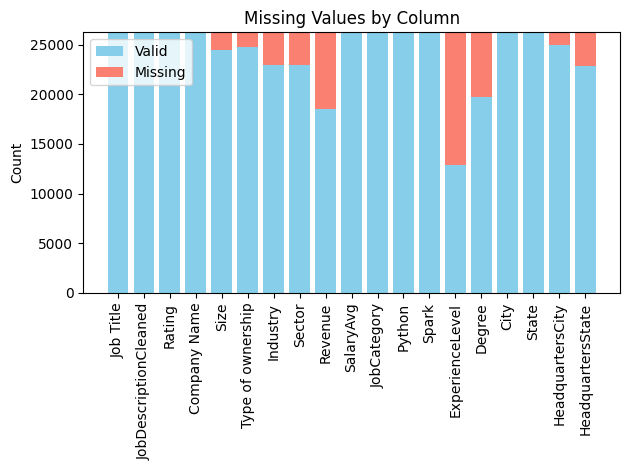

In [706]:
missing_counts = df.replace({-1: np.nan, 'Unknown': np.nan}).isnull().sum()
valid_counts = df.replace({-1: np.nan, 'Unknown': np.nan}).notnull().sum()
print(missing_counts)

categories = df.columns
x = range(len(categories))

plt.bar(x, valid_counts, label='Valid', color='skyblue')
plt.bar(x, missing_counts, bottom=valid_counts, label='Missing', color='salmon')
plt.xticks(x, categories, rotation=90)
plt.ylabel('Count')
plt.title('Missing Values by Column')
plt.legend()

plt.tight_layout()
plt.show()

In [707]:
df.head(1)

Job Title  \
0  business analyst - clinical & logistics platform   

                               JobDescriptionCleaned  Rating  \
0  company overview memorial sloan kettering msk ...     3.9   

               Company Name              Size       Type of ownership  \
0  memorial sloan-kettering  10000+ employees  Nonprofit Organization   

                           Industry       Sector                 Revenue  \
0  Health Care Services & Hospitals  Health Care  $2 to $5 billion (USD)   

   SalaryAvg       JobCategory  Python  Spark ExperienceLevel    Degree  \
0    79000.0  Business Analyst     0.0    0.0         Unknown  Bachelor   

       City State HeadquartersCity HeadquartersState  
0  New York    NY         New York                NY

In [708]:
columns_to_save = [
    'Job Title', 'Rating', 'Company Name', 'City', 'State', 'HeadquartersCity', 'HeadquartersState', 'Size',
    'Type of ownership', 'Industry', 'Sector', 'Revenue', 'SalaryAvg',
    'JobCategory', 'Python', 'Spark', 'ExperienceLevel', 'Degree'
]

df_selected = df[columns_to_save]

df_selected.to_csv('selected_job_data.csv', index=False)
del df_selected


**Model**

In [709]:
selected_columns = ['Rating', 'Company Name', 'JobCategory', 'Size', 'Revenue', 'Type of ownership', 'Industry',	'City', 'State', 'HeadquartersCity', 'HeadquartersState', 'SalaryAvg'
 , 'Python', 'Spark', 'Degree'
]
df_selected = df[selected_columns].copy()
print(df_selected.head())
del df

   Rating              Company Name       JobCategory                   Size  \
0     3.9  memorial sloan-kettering  Business Analyst       10000+ employees   
1     3.8   paine schwartz partners  Business Analyst      1 to 50 employees   
2     3.6                   asembia      Data Analyst  501 to 1000 employees   
3     3.6                        bd  Business Analyst       10000+ employees   
4     3.4           rubicon project  Business Analyst   201 to 500 employees   

                      Revenue       Type of ownership  \
0      $2 to $5 billion (USD)  Nonprofit Organization   
1                     Unknown       Company - Private   
2     $5 to $10 million (USD)       Company - Private   
3          $10+ billion (USD)        Company - Public   
4  $100 to $500 million (USD)        Company - Public   

                             Industry            City State HeadquartersCity  \
0    Health Care Services & Hospitals        New York    NY         New York   
1    Venture Cap

Нормалізація, енкодинг

In [710]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26248 entries, 0 to 26979
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Rating             26248 non-null  float64
 1   Company Name       26248 non-null  object 
 2   JobCategory        26248 non-null  object 
 3   Size               26248 non-null  object 
 4   Revenue            26248 non-null  object 
 5   Type of ownership  26248 non-null  object 
 6   Industry           26248 non-null  object 
 7   City               26248 non-null  object 
 8   State              26248 non-null  object 
 9   HeadquartersCity   26248 non-null  object 
 10  HeadquartersState  26248 non-null  object 
 11  SalaryAvg          26248 non-null  float64
 12  Python             26248 non-null  float64
 13  Spark              26248 non-null  float64
 14  Degree             26248 non-null  object 
dtypes: float64(4), object(11)
memory usage: 3.2+ MB


In [711]:
X = df_selected.drop(columns=['SalaryAvg'])
y = df_selected['SalaryAvg']

print("X")
print(X.head())
print("\ny")
print(y.head())

X
   Rating              Company Name       JobCategory                   Size  \
0     3.9  memorial sloan-kettering  Business Analyst       10000+ employees   
1     3.8   paine schwartz partners  Business Analyst      1 to 50 employees   
2     3.6                   asembia      Data Analyst  501 to 1000 employees   
3     3.6                        bd  Business Analyst       10000+ employees   
4     3.4           rubicon project  Business Analyst   201 to 500 employees   

                      Revenue       Type of ownership  \
0      $2 to $5 billion (USD)  Nonprofit Organization   
1                     Unknown       Company - Private   
2     $5 to $10 million (USD)       Company - Private   
3          $10+ billion (USD)        Company - Public   
4  $100 to $500 million (USD)        Company - Public   

                             Industry            City State HeadquartersCity  \
0    Health Care Services & Hospitals        New York    NY         New York   
1    Venture C

In [712]:
# X.replace("Unknown", np.nan, inplace=True)

In [713]:
numerical_columns = ['Rating']
scaler = MinMaxScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

print(X[numerical_columns].head())
y = scaler.fit_transform(y.values.reshape(-1, 1))
# print(y[:15])
# print(y[-5:])

   Rating
0   0.725
1   0.700
2   0.650
3   0.650
4   0.600


In [714]:
target_columns = ['Company Name', 'JobCategory', 'Industry','Type of ownership', 'City', 'State', 'HeadquartersCity', 'HeadquartersState']
# for col in target_columns:
#     print(X[col].value_counts())


In [715]:
print(type(y))
print(y.dtype)


<class 'numpy.ndarray'>
float64


In [716]:
# TargetEncoding
print(y.shape)
y = y.squeeze()
# print(y)
print(y.shape)
encoder = TargetEncoder(random_state=42)

for col in target_columns:
    X[col] = encoder.fit_transform(X[[col]], y)

# print("After Target Encoding:")
# print(X[target_columns].head())
# print(X[target_columns].tail())


(26248, 1)
(26248,)


In [717]:
# OrdinalEncoding
size_mapping = {
    '1 to 50 employees': 1,
    '51 to 200 employees': 2,
    '201 to 500 employees': 3,
    '501 to 1000 employees': 4,
    '1001 to 5000 employees': 5,
    '5001 to 10000 employees': 6,
    '10000+ employees': 7,
    'Unknown': 0
}

revenue_mapping = {
    'Unknown': 0,
    'Less than $1 million (USD)': 1,
    '$1 to $5 million (USD)': 2,
    '$5 to $10 million (USD)': 3,
    '$10 to $25 million (USD)': 4,
    '$25 to $50 million (USD)': 5,
    '$50 to $100 million (USD)': 6,
    '$100 to $500 million (USD)': 7,
    '$500 million to $1 billion (USD)': 8,
    '$1 to $2 billion (USD)': 9,
    '$2 to $5 billion (USD)': 10,
    '$5 to $10 billion (USD)': 11,
    '$10+ billion (USD)': 12
}

# level_mapping = {
#     'Unknown': 0,
#     'Senior' :4,
#     'Junior' :2,
#     'Middle'   :3,
#     'Intern/Trainee' :1
# }

degree_mapping = {
    'Unknown': 0,
    'Bachelor' :1,
    'Master' :2,
    'PhD'   :3
}

X['Size'] = X['Size'].map(size_mapping)
X['Revenue'] = X['Revenue'].map(revenue_mapping)
# X['ExperienceLevel'] = X['ExperienceLevel'].map(level_mapping)
X['Degree'] = X['Degree'].map(degree_mapping)
print("З Ordinal Encoding:")
print(X[['Size', 'Revenue'
# , 'ExperienceLevel'
, 'Degree'
]].head())


З Ordinal Encoding:
   Size  Revenue  Degree
0     7       10       1
1     1        0       2
2     4        3       1
3     7       12       0
4     3        7       2


In [718]:
X.head()

Rating  Company Name  JobCategory  Size  Revenue  Type of ownership  \
0   0.725      0.196001     0.221008     7       10           0.234118   
1   0.700      0.239583     0.219759     1        0           0.242694   
2   0.650      0.239583     0.205872     4        3           0.242694   
3   0.650      0.261576     0.221008     7       12           0.248674   
4   0.600      0.239583     0.220514     3        7           0.247752   

   Industry      City     State  HeadquartersCity  HeadquartersState  Python  \
0  0.223478  0.298945  0.294328          0.269051           0.265206     0.0   
1  0.253263  0.296912  0.292781          0.270457           0.265469     0.0   
2  0.302921  0.348499  0.252097          0.189660           0.250665     0.0   
3  0.250472  0.252915  0.253941          0.261576           0.246080     0.0   
4  0.350824  0.300979  0.296543          0.297148           0.299123     0.0   

   Spark  Degree  
0    0.0       1  
1    0.0       2  
2    0.0       1  
3    0.0       0  
4    0.0       2

In [719]:
y = pd.Series(y)

# correlation_with_target = X.corrwith(y)
# print("X and y correlation:")
# print(correlation_with_target)


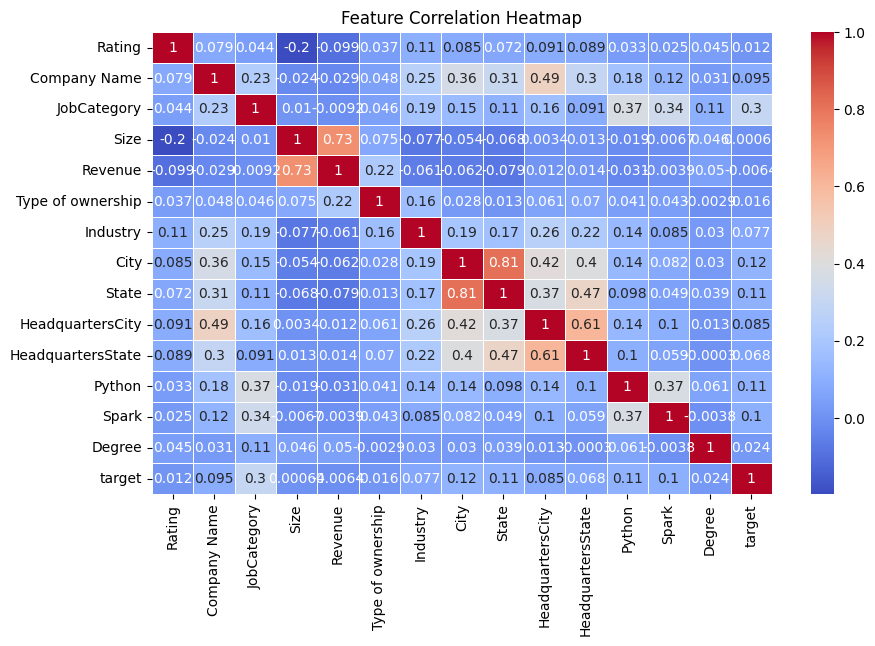

In [720]:
X_with_y = X.copy()
X_with_y['target'] = y
correlation_matrix = X_with_y.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

In [721]:
# X.info()

In [722]:
print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: (26248, 14)
y: (26248,)


In [723]:
# XGBoost

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(n_estimators=235, learning_rate=0.03, max_depth=10, subsample=0.7, colsample_bytree = 0.6, random_state=42)
xgb_model.fit(X_train, y_train)


y_pred_xgb = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_xgb)
mae = mean_absolute_error(y_test, y_pred_xgb)
r2 = r2_score(y_test, y_pred_xgb)

print(f"MSE: {mse}, MAE: {mae}, R2: {r2}")



MSE: 0.013099576682253285, MAE: 0.0861215115832904, R2: 0.42710966267356365


<Figure size 1000x600 with 0 Axes>

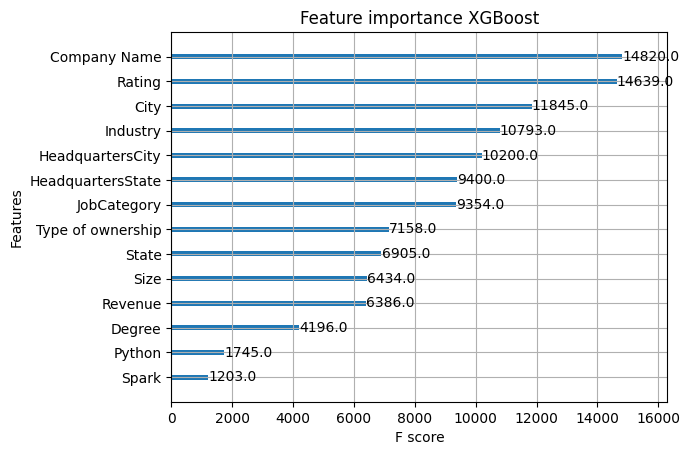

In [724]:
plt.figure(figsize=(10, 6))
plot_importance(xgb_model, max_num_features=20, importance_type='weight')
plt.title("Feature importance XGBoost")
plt.show()


In [725]:
indices = range(5)
multiple_samples = X_test.iloc[indices]
predicted_values_scaled = xgb_model.predict(multiple_samples)

predicted_values = scaler.inverse_transform(predicted_values_scaled.reshape(-1, 1)).flatten()

true_values_scaled = y_test.iloc[indices].values.reshape(-1, 1)
true_values = scaler.inverse_transform(true_values_scaled).flatten()

for i, (pred, true) in enumerate(zip(predicted_values, true_values)):
    print(f"Sample {i}: Predicted Value = {pred}, True Value = {true}")


Sample 0: Predicted Value = 82488.625, True Value = 99000.0
Sample 1: Predicted Value = 70790.421875, True Value = 64500.0
Sample 2: Predicted Value = 84687.1640625, True Value = 66000.0
Sample 3: Predicted Value = 96525.1015625, True Value = 92500.0
Sample 4: Predicted Value = 126887.46875, True Value = 158000.0
